In [293]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

from matplotlib.ticker import FormatStrFormatter

import seaborn as sns
import geopandas as gpd
from sklearn.model_selection import StratifiedGroupKFold, StratifiedKFold, StratifiedShuffleSplit
from sklearn.preprocessing import OneHotEncoder

from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_squared_error
from scipy import stats



In [2]:
county_ses_vars = gpd.read_file('../data/facility_distance_added.geojson', dtype = {'academic_year': str, 'Year': str})
county_ses_vars

/Users/julia/Library/Python/3.9/lib/python/site-packages/pyogrio/raw.py:198: RuntimeWarning: driver GeoJSON does not support open option DTYPE
  return ogr_read(


,STATEFP,COUNTYF,COUNTYN,GEOIDFQ,GEOID,NAME,NAMELSA,STUSPS,STATE_N,LSAD,...,SA,MH,YOUTH,YOUTH_close,YOUTH_average_distance,SA_close,SA_average_distance,MH_close,MH_average_distance,geometry
0,08,067,00198148,0500000US08067,08067,La Plata,La Plata County,CO,Colorado,06,...,3.0,3.0,5.0,3346.514328,6548.284689,3346.514328,36632.632633,3346.514328,37116.375033,"POLYGON ((-108.37961 37.00418, -108.37643 37.0..."
1,08,067,00198148,0500000US08067,08067,La Plata,La Plata County,CO,Colorado,06,...,5.0,2.0,6.0,7285.721338,12244.846774,1700.696414,10340.000387,7285.721338,54744.029883,"POLYGON ((-108.37961 37.00418, -108.37643 37.0..."
2,08,113,00198172,0500000US08113,08113,San Miguel,San Miguel County,CO,Colorado,06,...,NaN,NaN,NaN,93121.149249,97130.606256,89065.050286,100947.574632,93121.149249,122365.806378,"POLYGON ((-109.04282 37.99707, -109.04282 37.9..."
3,08,113,00198172,0500000US08113,08113,San Miguel,San Miguel County,CO,Colorado,06,...,2.0,2.0,2.0,21745.615746,71758.687975,21745.615746,71959.243414,21745.615746,75136.275804,"POLYGON ((-109.04282 37.99707, -109.04282 37.9..."
4,04,009,00025444,0500000US04009,04009,Graham,Graham County,AZ,Arizona,06,...,5.0,5.0,10.0,22513.571302,23170.583808,22513.571302,24145.875831,22513.571302,23787.127318,"POLYGON ((-110.45719 33.29527, -110.45299 33.2..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2920,33,None,None,None,3307115,Wilton-Lyndeborough School District,None,NH,None,00,...,NaN,NaN,NaN,19319.294403,31688.587918,20162.576148,27429.384980,19319.294403,30443.103154,"POLYGON ((-71.83018 42.87508, -71.83213 42.884..."
2921,33,None,None,None,3307170,Windham School District,None,NH,None,00,...,NaN,NaN,NaN,8341.958514,11522.204785,10738.473654,16441.431956,8341.958514,17269.310344,"POLYGON ((-71.36454 42.78551, -71.36445 42.785..."
2922,33,None,None,None,3307200,Windsor School District,None,NH,None,00,...,0.0,1.0,4.0,722.207981,6897.424469,15557.302690,33164.130239,722.207981,30312.580485,"POLYGON ((-72.04213 43.08221, -72.0435 43.0819..."
2923,33,None,None,None,3307300,Winnisquam Regional School District,None,NH,None,00,...,0.0,1.0,1.0,6451.678706,8298.575488,6770.032674,13220.862973,6451.678706,10056.222180,"POLYGON ((-71.63055 43.47831, -71.63064 43.478..."


In [3]:
county_ses_vars['STUSPS'].unique()

array(['CO', 'AZ', 'KS', 'NY', 'OR', 'PA', 'TX', 'VA', 'WI', 'GA', 'LA',
       'MA', 'MI', 'NH', 'AK'], dtype=object)

In [4]:
# remove CO
county_ses_vars = county_ses_vars[county_ses_vars['STUSPS']!='CO'].reset_index(drop=True)
county_ses_vars

,STATEFP,COUNTYF,COUNTYN,GEOIDFQ,GEOID,NAME,NAMELSA,STUSPS,STATE_N,LSAD,...,SA,MH,YOUTH,YOUTH_close,YOUTH_average_distance,SA_close,SA_average_distance,MH_close,MH_average_distance,geometry
0,04,009,00025444,0500000US04009,04009,Graham,Graham County,AZ,Arizona,06,...,5.0,5.0,10.0,22513.571302,23170.583808,22513.571302,24145.875831,22513.571302,23787.127318,"POLYGON ((-110.45719 33.29527, -110.45299 33.2..."
1,04,009,00025444,0500000US04009,04009,Graham,Graham County,AZ,Arizona,06,...,3.0,5.0,8.0,22513.571302,23170.583808,23962.344318,62879.270157,22513.571302,23787.127318,"POLYGON ((-110.45719 33.29527, -110.45299 33.2..."
2,20,199,00485060,0500000US20199,20199,Wallace,Wallace County,KS,Kansas,06,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"POLYGON ((-102.04719 39.13315, -102.02582 39.1..."
3,36,013,00974105,0500000US36013,36013,Chautauqua,Chautauqua County,NY,New York,06,...,6.0,4.0,7.0,18759.997603,24969.029659,18759.997603,26411.340150,24303.463050,36268.268074,"POLYGON ((-79.76215 42.24305, -79.76196 42.251..."
4,36,013,00974105,0500000US36013,36013,Chautauqua,Chautauqua County,NY,New York,06,...,10.0,5.0,10.0,18759.997603,24969.029659,18759.997603,23543.221980,24303.463050,30340.155747,"POLYGON ((-79.76215 42.24305, -79.76196 42.251..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2792,33,None,None,None,3307115,Wilton-Lyndeborough School District,None,NH,None,00,...,NaN,NaN,NaN,19319.294403,31688.587918,20162.576148,27429.384980,19319.294403,30443.103154,"POLYGON ((-71.83018 42.87508, -71.83213 42.884..."
2793,33,None,None,None,3307170,Windham School District,None,NH,None,00,...,NaN,NaN,NaN,8341.958514,11522.204785,10738.473654,16441.431956,8341.958514,17269.310344,"POLYGON ((-71.36454 42.78551, -71.36445 42.785..."
2794,33,None,None,None,3307200,Windsor School District,None,NH,None,00,...,0.0,1.0,4.0,722.207981,6897.424469,15557.302690,33164.130239,722.207981,30312.580485,"POLYGON ((-72.04213 43.08221, -72.0435 43.0819..."
2795,33,None,None,None,3307300,Winnisquam Regional School District,None,NH,None,00,...,0.0,1.0,1.0,6451.678706,8298.575488,6770.032674,13220.862973,6451.678706,10056.222180,"POLYGON ((-71.63055 43.47831, -71.63064 43.478..."


In [6]:
county_ses_vars = county_ses_vars[~county_ses_vars['Year'].isna()].reset_index(drop  = True)
county_ses_vars

,STATEFP,COUNTYF,COUNTYN,GEOIDFQ,GEOID,NAME,NAMELSA,STUSPS,STATE_N,LSAD,...,SA,MH,YOUTH,YOUTH_close,YOUTH_average_distance,SA_close,SA_average_distance,MH_close,MH_average_distance,geometry
0,04,009,00025444,0500000US04009,04009,Graham,Graham County,AZ,Arizona,06,...,5.0,5.0,10.0,22513.571302,23170.583808,22513.571302,24145.875831,22513.571302,23787.127318,"POLYGON ((-110.45719 33.29527, -110.45299 33.2..."
1,04,009,00025444,0500000US04009,04009,Graham,Graham County,AZ,Arizona,06,...,3.0,5.0,8.0,22513.571302,23170.583808,23962.344318,62879.270157,22513.571302,23787.127318,"POLYGON ((-110.45719 33.29527, -110.45299 33.2..."
2,36,013,00974105,0500000US36013,36013,Chautauqua,Chautauqua County,NY,New York,06,...,6.0,4.0,7.0,18759.997603,24969.029659,18759.997603,26411.340150,24303.463050,36268.268074,"POLYGON ((-79.76215 42.24305, -79.76196 42.251..."
3,36,013,00974105,0500000US36013,36013,Chautauqua,Chautauqua County,NY,New York,06,...,10.0,5.0,10.0,18759.997603,24969.029659,18759.997603,23543.221980,24303.463050,30340.155747,"POLYGON ((-79.76215 42.24305, -79.76196 42.251..."
4,36,045,00974121,0500000US36045,36045,Jefferson,Jefferson County,NY,New York,06,...,7.0,3.0,11.0,10338.612315,11549.649793,10338.612315,11353.500676,11505.977227,49685.024808,"MULTIPOLYGON (((-76.14744 43.94282, -76.14566 ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2657,33,None,None,None,3307115,Wilton-Lyndeborough School District,None,NH,None,00,...,NaN,NaN,NaN,19319.294403,31688.587918,20162.576148,27429.384980,19319.294403,30443.103154,"POLYGON ((-71.83018 42.87508, -71.83213 42.884..."
2658,33,None,None,None,3307170,Windham School District,None,NH,None,00,...,NaN,NaN,NaN,8341.958514,11522.204785,10738.473654,16441.431956,8341.958514,17269.310344,"POLYGON ((-71.36454 42.78551, -71.36445 42.785..."
2659,33,None,None,None,3307200,Windsor School District,None,NH,None,00,...,0.0,1.0,4.0,722.207981,6897.424469,15557.302690,33164.130239,722.207981,30312.580485,"POLYGON ((-72.04213 43.08221, -72.0435 43.0819..."
2660,33,None,None,None,3307300,Winnisquam Regional School District,None,NH,None,00,...,0.0,1.0,1.0,6451.678706,8298.575488,6770.032674,13220.862973,6451.678706,10056.222180,"POLYGON ((-71.63055 43.47831, -71.63064 43.478..."


In [7]:
county_ses_vars[county_ses_vars['dropout_rate'].isna()].groupby('Year').size()

Year
2022.0     50
2023.0    247
dtype: int64

In [8]:
county_ses_vars.columns.tolist()

['STATEFP',
 'COUNTYF',
 'COUNTYN',
 'GEOIDFQ',
 'GEOID',
 'NAME',
 'NAMELSA',
 'STUSPS',
 'STATE_N',
 'LSAD',
 'ALAND',
 'AWATER',
 'DR_ID',
 'academic_year',
 'number_of_student',
 'number_of_dropout',
 'dropout_rate',
 'number_of_male',
 'dropout_male',
 'dropout_male_rate',
 'number_of_female',
 'dropout_female',
 'dropout_female_rate',
 'number_of_asian',
 'dropout_asian',
 'dropout_asian_rate',
 'number_of_american_native',
 'dropout_american_native',
 'dropout_american_native_rate',
 'number_of_black',
 'dropout_black',
 'dropout_black_rate',
 'number_of_white',
 'dropout_white',
 'dropout_white_rate',
 'number_of_hispanic',
 'dropout_hispanic',
 'dropout_hispanic_rate',
 'number_of_english_learner',
 'dropout_english_learner',
 'dropout_english_learner_rate',
 'number_of_student_with_disability',
 'dropout_student_with_disability',
 'dropout_student_with_disability_rate',
 'number_of_economically_disadvantaged',
 'dropout_economically_disadvantaged',
 'dropout_economically_disa

In [9]:
county_ses_vars[county_ses_vars['dropout_rate'].notna()]

,STATEFP,COUNTYF,COUNTYN,GEOIDFQ,GEOID,NAME,NAMELSA,STUSPS,STATE_N,LSAD,...,SA,MH,YOUTH,YOUTH_close,YOUTH_average_distance,SA_close,SA_average_distance,MH_close,MH_average_distance,geometry
0,04,009,00025444,0500000US04009,04009,Graham,Graham County,AZ,Arizona,06,...,5.0,5.0,10.0,22513.571302,23170.583808,22513.571302,24145.875831,22513.571302,23787.127318,"POLYGON ((-110.45719 33.29527, -110.45299 33.2..."
1,04,009,00025444,0500000US04009,04009,Graham,Graham County,AZ,Arizona,06,...,3.0,5.0,8.0,22513.571302,23170.583808,23962.344318,62879.270157,22513.571302,23787.127318,"POLYGON ((-110.45719 33.29527, -110.45299 33.2..."
2,36,013,00974105,0500000US36013,36013,Chautauqua,Chautauqua County,NY,New York,06,...,6.0,4.0,7.0,18759.997603,24969.029659,18759.997603,26411.340150,24303.463050,36268.268074,"POLYGON ((-79.76215 42.24305, -79.76196 42.251..."
3,36,013,00974105,0500000US36013,36013,Chautauqua,Chautauqua County,NY,New York,06,...,10.0,5.0,10.0,18759.997603,24969.029659,18759.997603,23543.221980,24303.463050,30340.155747,"POLYGON ((-79.76215 42.24305, -79.76196 42.251..."
4,36,045,00974121,0500000US36045,36045,Jefferson,Jefferson County,NY,New York,06,...,7.0,3.0,11.0,10338.612315,11549.649793,10338.612315,11353.500676,11505.977227,49685.024808,"MULTIPOLYGON (((-76.14744 43.94282, -76.14566 ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2657,33,None,None,None,3307115,Wilton-Lyndeborough School District,None,NH,None,00,...,NaN,NaN,NaN,19319.294403,31688.587918,20162.576148,27429.384980,19319.294403,30443.103154,"POLYGON ((-71.83018 42.87508, -71.83213 42.884..."
2658,33,None,None,None,3307170,Windham School District,None,NH,None,00,...,NaN,NaN,NaN,8341.958514,11522.204785,10738.473654,16441.431956,8341.958514,17269.310344,"POLYGON ((-71.36454 42.78551, -71.36445 42.785..."
2659,33,None,None,None,3307200,Windsor School District,None,NH,None,00,...,0.0,1.0,4.0,722.207981,6897.424469,15557.302690,33164.130239,722.207981,30312.580485,"POLYGON ((-72.04213 43.08221, -72.0435 43.0819..."
2660,33,None,None,None,3307300,Winnisquam Regional School District,None,NH,None,00,...,0.0,1.0,1.0,6451.678706,8298.575488,6770.032674,13220.862973,6451.678706,10056.222180,"POLYGON ((-71.63055 43.47831, -71.63064 43.478..."


### Features distribution

In [17]:
ls = ['academic_year',
 'number_of_student',
 'number_of_dropout',
 'dropout_rate',
 'Year',
 'total_population',
 'male_population',
 'female_population',
 'pop_15_19F',
 'pop_15_19M',
 'male_under_18',
 'female_under_18',
 'median_age',
 'white',
 'black',
 'hispanic',
 'asian',
 'american_indian_alaskan_native',
 'hawaiian_native_or_other_pacific_islander',
 'other_race',
 'two_or_more_races',
 'population_english_only_percentage',
 'population_other_than_english_percentage',
 'population_English_less_percentage',
 'disability_under_18',
 'white_disability_under18',
 'hispanic_disability_under18',
 'black_disability_under18',
 'american_indian_alaskan_native_disability_under18',
 'asian_disability_under18',
 'hawaiian_native_or_other_pacific_islander_disability_under18',
 'other_race_disability_under18',
 'two_or_more_races_disability_under18',
 'foreign_born_percentage',
 'number_of_households',
 'median_income',
 'labor_force_count',
 'mean_commute_time',
 'households_with_computing_devices',
 'households_with_internet_access',
 'married',
 'divorced',
 'widowed',
 'never_married',
 'poverty_married_couple_family_5_17',
 'less_than_high_school',
 'highschool_or_higher',
 'bachelors_or_higher',
 'masters_or_higher',
 'total_housing_unit_occupancy',
 'vacant_percentage',
 'owner_occupied_percentage',
 'renter_occupied_percentage',
 'total_health_coverage',
 'public_percentage',
 'private_percentage',
 'medicare_percentage',
 'medicaid_percentage',
 'public_male_under_18',
 'public_female_under_18',
 'private_male_under_18',
 'private_female_under_18',
 'medicare_male_under18',
 'medicare_female_under18',
 'medicaid_male_under18',
 'medicaid_female_under18',
 'population_under_18',
 'disability_rate_under_18',
 'public_total',
 'private_total',
 'medicare_total',
 'SA',
 'MH',
 'YOUTH',
 'YOUTH_close',
 'YOUTH_average_distance',
 'SA_close',
 'SA_average_distance',
 'MH_close',
 'MH_average_distance'
]
nan_counts = county_ses_vars[ls].isnull().sum().reset_index()
nan_counts[nan_counts[0]>0].sort_values(by = 0, ascending=False)


,index,0
21,population_english_only_percentage,2662
22,population_other_than_english_percentage,2662
23,population_English_less_percentage,2662
71,SA,1020
72,MH,1020
73,YOUTH,1020
2,number_of_dropout,506
1,number_of_student,310
3,dropout_rate,297
12,median_age,53


In [ ]:
county_ses_vars[county_ses_vars['median_age'].isna()] # all of them are AK

,STATEFP,COUNTYF,COUNTYN,GEOIDFQ,GEOID,NAME,NAMELSA,STUSPS,STATE_N,LSAD,...,SA,MH,YOUTH,YOUTH_close,YOUTH_average_distance,SA_close,SA_average_distance,MH_close,MH_average_distance,geometry
1924,02,None,None,None,0200001,Lower Kuskokwim School District,None,AK,None,00,...,3.0,3.0,10.0,1.098727e+05,1.098727e+05,1.098727e+05,5.246041e+05,1.098727e+05,4.947946e+05,"MULTIPOLYGON (((-161.3313 58.73934, -161.3313 ..."
1925,02,None,None,None,0200003,Lower Yukon School District,None,AK,None,00,...,NaN,NaN,NaN,3.538901e+05,3.538901e+05,3.538901e+05,5.864904e+05,3.538901e+05,5.864904e+05,"MULTIPOLYGON (((-160.75505 61.28806, -160.7542..."
1926,02,None,None,None,0200004,Yupiit School District,None,AK,None,00,...,NaN,NaN,NaN,6.603862e+04,7.175227e+04,6.603862e+04,4.618421e+05,6.603862e+04,4.616510e+05,"MULTIPOLYGON (((-161.22561 60.92058, -161.2218..."
1927,02,None,None,None,0200005,Kashunamiut School District,None,AK,None,00,...,NaN,NaN,NaN,4.502304e+05,4.502304e+05,4.502304e+05,7.032082e+05,4.502304e+05,7.032082e+05,"POLYGON ((-165.61099 61.52596, -165.61099 61.5..."
1928,02,None,None,None,0200007,Aleutians East Borough School District,None,AK,None,00,...,0.0,2.0,2.0,7.134452e+04,6.199662e+05,1.140207e+06,1.271563e+06,7.134452e+04,6.207261e+05,"MULTIPOLYGON (((-162.44108 54.40669, -162.4347..."
1929,02,None,None,None,0200010,Aleutian Region School District,None,AK,None,00,...,NaN,NaN,NaN,1.289389e+06,1.633456e+06,1.289389e+06,1.640365e+06,1.289389e+06,1.640859e+06,"MULTIPOLYGON (((-178.28185 51.48377, -178.2779..."
1930,02,None,None,None,0200020,Bering Strait School District,None,AK,None,00,...,NaN,NaN,NaN,1.874040e+05,4.901819e+05,1.874040e+05,7.736644e+05,1.874040e+05,7.736644e+05,"MULTIPOLYGON (((-160.67129 63.27184, -160.6725..."
1931,02,None,None,None,0200030,Bristol Bay Borough School District,None,AK,None,00,...,NaN,NaN,NaN,5.223796e+05,5.744921e+05,6.081714e+05,6.548712e+05,5.223796e+05,6.606939e+05,"POLYGON ((-156.43939 58.61667, -156.44509 58.6..."
1932,02,None,None,None,0200050,Alaska Gateway School District,None,AK,None,00,...,1.0,1.0,2.0,1.005532e+05,3.718050e+05,1.005532e+05,4.471629e+05,1.005532e+05,5.035394e+05,"POLYGON ((-142.01591 62.24708, -142.01652 62.2..."
1933,02,None,None,None,0200060,Cordova City School District,None,AK,None,00,...,1.0,1.0,2.0,1.590254e+04,1.024237e+05,1.590254e+04,2.742862e+05,1.590254e+04,2.774128e+05,"MULTIPOLYGON (((-145.86411 60.50344, -145.8638..."


In [19]:
county_ses_vars[county_ses_vars['median_income'].isna()] # all of them are AK

,STATEFP,COUNTYF,COUNTYN,GEOIDFQ,GEOID,NAME,NAMELSA,STUSPS,STATE_N,LSAD,...,SA,MH,YOUTH,YOUTH_close,YOUTH_average_distance,SA_close,SA_average_distance,MH_close,MH_average_distance,geometry
1924,02,None,None,None,0200001,Lower Kuskokwim School District,None,AK,None,00,...,3.0,3.0,10.0,1.098727e+05,1.098727e+05,1.098727e+05,5.246041e+05,1.098727e+05,4.947946e+05,"MULTIPOLYGON (((-161.3313 58.73934, -161.3313 ..."
1925,02,None,None,None,0200003,Lower Yukon School District,None,AK,None,00,...,NaN,NaN,NaN,3.538901e+05,3.538901e+05,3.538901e+05,5.864904e+05,3.538901e+05,5.864904e+05,"MULTIPOLYGON (((-160.75505 61.28806, -160.7542..."
1926,02,None,None,None,0200004,Yupiit School District,None,AK,None,00,...,NaN,NaN,NaN,6.603862e+04,7.175227e+04,6.603862e+04,4.618421e+05,6.603862e+04,4.616510e+05,"MULTIPOLYGON (((-161.22561 60.92058, -161.2218..."
1927,02,None,None,None,0200005,Kashunamiut School District,None,AK,None,00,...,NaN,NaN,NaN,4.502304e+05,4.502304e+05,4.502304e+05,7.032082e+05,4.502304e+05,7.032082e+05,"POLYGON ((-165.61099 61.52596, -165.61099 61.5..."
1928,02,None,None,None,0200007,Aleutians East Borough School District,None,AK,None,00,...,0.0,2.0,2.0,7.134452e+04,6.199662e+05,1.140207e+06,1.271563e+06,7.134452e+04,6.207261e+05,"MULTIPOLYGON (((-162.44108 54.40669, -162.4347..."
1929,02,None,None,None,0200010,Aleutian Region School District,None,AK,None,00,...,NaN,NaN,NaN,1.289389e+06,1.633456e+06,1.289389e+06,1.640365e+06,1.289389e+06,1.640859e+06,"MULTIPOLYGON (((-178.28185 51.48377, -178.2779..."
1930,02,None,None,None,0200020,Bering Strait School District,None,AK,None,00,...,NaN,NaN,NaN,1.874040e+05,4.901819e+05,1.874040e+05,7.736644e+05,1.874040e+05,7.736644e+05,"MULTIPOLYGON (((-160.67129 63.27184, -160.6725..."
1931,02,None,None,None,0200030,Bristol Bay Borough School District,None,AK,None,00,...,NaN,NaN,NaN,5.223796e+05,5.744921e+05,6.081714e+05,6.548712e+05,5.223796e+05,6.606939e+05,"POLYGON ((-156.43939 58.61667, -156.44509 58.6..."
1932,02,None,None,None,0200050,Alaska Gateway School District,None,AK,None,00,...,1.0,1.0,2.0,1.005532e+05,3.718050e+05,1.005532e+05,4.471629e+05,1.005532e+05,5.035394e+05,"POLYGON ((-142.01591 62.24708, -142.01652 62.2..."
1933,02,None,None,None,0200060,Cordova City School District,None,AK,None,00,...,1.0,1.0,2.0,1.590254e+04,1.024237e+05,1.590254e+04,2.742862e+05,1.590254e+04,2.774128e+05,"MULTIPOLYGON (((-145.86411 60.50344, -145.8638..."


In [22]:
county_ses_vars[county_ses_vars['median_income'].notna() & (county_ses_vars['STUSPS'] == 'AK')]

,STATEFP,COUNTYF,COUNTYN,GEOIDFQ,GEOID,NAME,NAMELSA,STUSPS,STATE_N,LSAD,...,SA,MH,YOUTH,YOUTH_close,YOUTH_average_distance,SA_close,SA_average_distance,MH_close,MH_average_distance,geometry


In [23]:
county_ses_vars[ (county_ses_vars['STUSPS'] == 'AK')].shape

(53, 132)

In [24]:
county_ses_vars[county_ses_vars['dropout_rate'].isna() & (county_ses_vars['STUSPS'] == 'AK')]

,STATEFP,COUNTYF,COUNTYN,GEOIDFQ,GEOID,NAME,NAMELSA,STUSPS,STATE_N,LSAD,...,SA,MH,YOUTH,YOUTH_close,YOUTH_average_distance,SA_close,SA_average_distance,MH_close,MH_average_distance,geometry


In [25]:
# remove AK for the ML training
county_ses_vars = county_ses_vars[county_ses_vars['STUSPS'] != 'AK'].reset_index(drop = True)
county_ses_vars

,STATEFP,COUNTYF,COUNTYN,GEOIDFQ,GEOID,NAME,NAMELSA,STUSPS,STATE_N,LSAD,...,SA,MH,YOUTH,YOUTH_close,YOUTH_average_distance,SA_close,SA_average_distance,MH_close,MH_average_distance,geometry
0,04,009,00025444,0500000US04009,04009,Graham,Graham County,AZ,Arizona,06,...,5.0,5.0,10.0,22513.571302,23170.583808,22513.571302,24145.875831,22513.571302,23787.127318,"POLYGON ((-110.45719 33.29527, -110.45299 33.2..."
1,04,009,00025444,0500000US04009,04009,Graham,Graham County,AZ,Arizona,06,...,3.0,5.0,8.0,22513.571302,23170.583808,23962.344318,62879.270157,22513.571302,23787.127318,"POLYGON ((-110.45719 33.29527, -110.45299 33.2..."
2,36,013,00974105,0500000US36013,36013,Chautauqua,Chautauqua County,NY,New York,06,...,6.0,4.0,7.0,18759.997603,24969.029659,18759.997603,26411.340150,24303.463050,36268.268074,"POLYGON ((-79.76215 42.24305, -79.76196 42.251..."
3,36,013,00974105,0500000US36013,36013,Chautauqua,Chautauqua County,NY,New York,06,...,10.0,5.0,10.0,18759.997603,24969.029659,18759.997603,23543.221980,24303.463050,30340.155747,"POLYGON ((-79.76215 42.24305, -79.76196 42.251..."
4,36,045,00974121,0500000US36045,36045,Jefferson,Jefferson County,NY,New York,06,...,7.0,3.0,11.0,10338.612315,11549.649793,10338.612315,11353.500676,11505.977227,49685.024808,"MULTIPOLYGON (((-76.14744 43.94282, -76.14566 ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2604,33,None,None,None,3307115,Wilton-Lyndeborough School District,None,NH,None,00,...,NaN,NaN,NaN,19319.294403,31688.587918,20162.576148,27429.384980,19319.294403,30443.103154,"POLYGON ((-71.83018 42.87508, -71.83213 42.884..."
2605,33,None,None,None,3307170,Windham School District,None,NH,None,00,...,NaN,NaN,NaN,8341.958514,11522.204785,10738.473654,16441.431956,8341.958514,17269.310344,"POLYGON ((-71.36454 42.78551, -71.36445 42.785..."
2606,33,None,None,None,3307200,Windsor School District,None,NH,None,00,...,0.0,1.0,4.0,722.207981,6897.424469,15557.302690,33164.130239,722.207981,30312.580485,"POLYGON ((-72.04213 43.08221, -72.0435 43.0819..."
2607,33,None,None,None,3307300,Winnisquam Regional School District,None,NH,None,00,...,0.0,1.0,1.0,6451.678706,8298.575488,6770.032674,13220.862973,6451.678706,10056.222180,"POLYGON ((-71.63055 43.47831, -71.63064 43.478..."


#### Generate some features based on raw numbers

In [26]:
county_ses_vars['total_pop_15_19'] = county_ses_vars['pop_15_19F'] + county_ses_vars['pop_15_19M']
county_ses_vars['pop_15_19F_rate'] = county_ses_vars['pop_15_19F'] / county_ses_vars['total_pop_15_19']
county_ses_vars['public_issurance_under18'] = county_ses_vars['public_male_under_18'] + county_ses_vars['public_female_under_18']
county_ses_vars['public_female_under_18_rate'] = county_ses_vars['public_female_under_18'] / county_ses_vars['public_issurance_under18']
county_ses_vars['private_issurance_under18'] = county_ses_vars['private_male_under_18'] + county_ses_vars['private_female_under_18']
county_ses_vars['private_female_under_18_rate'] = county_ses_vars['private_female_under_18'] / county_ses_vars['private_issurance_under18']

county_ses_vars['medicare_under18'] = county_ses_vars['medicare_male_under18'] + county_ses_vars['medicare_female_under18']
county_ses_vars['medicare_female_under18_rate'] = county_ses_vars['medicare_female_under18']/county_ses_vars['medicare_under18']

county_ses_vars['married_rate'] = county_ses_vars['married'] / (county_ses_vars['married'] + county_ses_vars['divorced'] + county_ses_vars['widowed'] + county_ses_vars['never_married'])
county_ses_vars['divorced_rate'] = county_ses_vars['divorced'] / (county_ses_vars['married'] + county_ses_vars['divorced'] + county_ses_vars['widowed'] + county_ses_vars['never_married'])
county_ses_vars['widowed_rate'] = county_ses_vars['widowed'] / (county_ses_vars['married'] + county_ses_vars['divorced'] + county_ses_vars['widowed'] + county_ses_vars['never_married'])

county_ses_vars['disability_rate_under_18_color'] = (county_ses_vars['disability_under_18'] - county_ses_vars['white_disability_under18'])/ (county_ses_vars['disability_under_18'])

county_ses_vars['bachelors_or_higher_rate'] = county_ses_vars['bachelors_or_higher'] / county_ses_vars['total_population']

In [27]:
features = ['STUSPS', 'Year', 'median_age', 'white', 'black', 'hispanic', 'asian','foreign_born_percentage',
'number_of_households', 'median_income', 'labor_force_count',
'mean_commute_time', 'households_with_computing_devices',
'households_with_internet_access', 'poverty_married_couple_family_5_17',
'total_housing_unit_occupancy','total_health_coverage', 'public_percentage','medicare_percentage',
'public_female_under_18_rate', 'public_issurance_under18', 'private_female_under_18_rate', 'private_issurance_under18',
'medicare_female_under18_rate', 'medicare_under18', 'disability_rate_under_18', 'disability_rate_under_18_color', 
'pop_15_19F_rate', 'total_pop_15_19',
'married_rate', 'divorced_rate', 'bachelors_or_higher_rate',
'YOUTH_close', 'YOUTH_average_distance', 'SA_close', 'SA_average_distance',
'MH_close', 'MH_average_distance']
len(features)

38

In [ ]:
nan_counts = county_ses_vars[features].isnull().sum().reset_index()
nan_counts[nan_counts[0]>0].sort_values(by = 0, ascending=False)


,index,0
23,medicare_female_under18_rate,572
26,disability_rate_under_18_color,38
19,public_female_under_18_rate,1


In [ ]:
county_ses_vars[county_ses_vars['medicare_under18'] == 0].shape # The nan happend when the sum is zero, so fill nan with 0

(572, 145)

In [34]:
county_ses_vars[features] = county_ses_vars[features].fillna(0)

In [35]:
nan_counts = county_ses_vars[features].isnull().sum().reset_index()
nan_counts[nan_counts[0]>0].sort_values(by = 0, ascending=False)

,index,0


In [36]:
def plot_feature_distributions(df, categorical_cols=[], bins=100):
    sns.set_context("talk", font_scale=1.2)

    num_cols = df.select_dtypes(include='number').columns.difference(categorical_cols)

    total_plots = len(num_cols) + len(categorical_cols)
    ncols = 5
    nrows = (total_plots + ncols - 1) // ncols

    plt.figure(figsize=(10 * ncols, 8 * nrows))

    plot_num = 1

    # Numerical features: histogram
    for col in num_cols:
        plt.subplot(nrows, ncols, plot_num)
        sns.histplot(df[col], bins=bins, kde=False, color='gray')
        # plt.title(f'{col}')
        plot_num += 1

    # Categorical features: bar plot
    for col in categorical_cols:
        plt.subplot(nrows, ncols, plot_num)
        sns.countplot(x=df[col], color='gray')
        # plt.title(f'{col}')
        plot_num += 1

    plt.tight_layout()
    plt.show()

In [37]:
county_ses_vars[features]

,STUSPS,Year,median_age,white,black,hispanic,asian,foreign_born_percentage,number_of_households,median_income,...,total_pop_15_19,married_rate,divorced_rate,bachelors_or_higher_rate,YOUTH_close,YOUTH_average_distance,SA_close,SA_average_distance,MH_close,MH_average_distance
0,AZ,2023.0,34.400000,25739.0000,498.0000,11769.0000,249.0000,0.015219,12460.0000,67326.000000,...,5159.0000,0.432809,0.186699,0.000004,22513.571302,23170.583808,22513.571302,24145.875831,22513.571302,23787.127318
1,AZ,2022.0,34.100000,26349.0000,759.0000,12885.0000,284.0000,0.014624,12018.0000,64089.000000,...,5304.0000,0.431264,0.190357,0.000004,22513.571302,23170.583808,23962.344318,62879.270157,22513.571302,23787.127318
2,NY,2022.0,42.800000,113168.0000,3352.0000,10333.0000,894.0000,0.013893,53405.0000,54625.000000,...,14645.0000,0.395637,0.190246,0.000002,18759.997603,24969.029659,18759.997603,26411.340150,24303.463050,36268.268074
3,NY,2023.0,42.700000,110294.0000,3384.0000,11792.0000,815.0000,0.013603,53602.0000,56507.000000,...,14424.0000,0.394661,0.189291,0.000002,18759.997603,24969.029659,18759.997603,23543.221980,24303.463050,30340.155747
4,NY,2022.0,32.800000,98846.0000,6888.0000,9326.0000,1842.0000,0.028725,46099.0000,62782.000000,...,16690.0000,0.412404,0.219904,0.000002,10338.612315,11549.649793,10338.612315,11353.500676,11505.977227,49685.024808
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2604,NH,2023.0,46.208325,5120.8914,0.0451,200.7850,57.9802,0.021307,2283.8666,107582.595402,...,642.8940,0.396822,0.225224,0.000072,19319.294403,31688.587918,20162.576148,27429.384980,19319.294403,30443.103154
2605,NH,2023.0,40.144937,13312.3354,131.2273,553.8463,1191.3736,0.078448,5459.2478,182102.643031,...,1932.4827,0.386339,0.251131,0.000041,8341.958514,11522.204785,10738.473654,16441.431956,8341.958514,17269.310344
2606,NH,2023.0,42.240039,195.9740,12.0555,11.4500,0.0150,0.019098,87.2400,92749.881520,...,13.2510,0.444641,0.203401,0.000526,722.207981,6897.424469,15557.302690,33164.130239,722.207981,30312.580485
2607,NH,2023.0,43.682519,11257.2547,113.8962,161.7014,73.9551,0.021260,4562.4207,85633.820316,...,1584.2356,0.385910,0.205822,0.000025,6451.678706,8298.575488,6770.032674,13220.862973,6451.678706,10056.222180


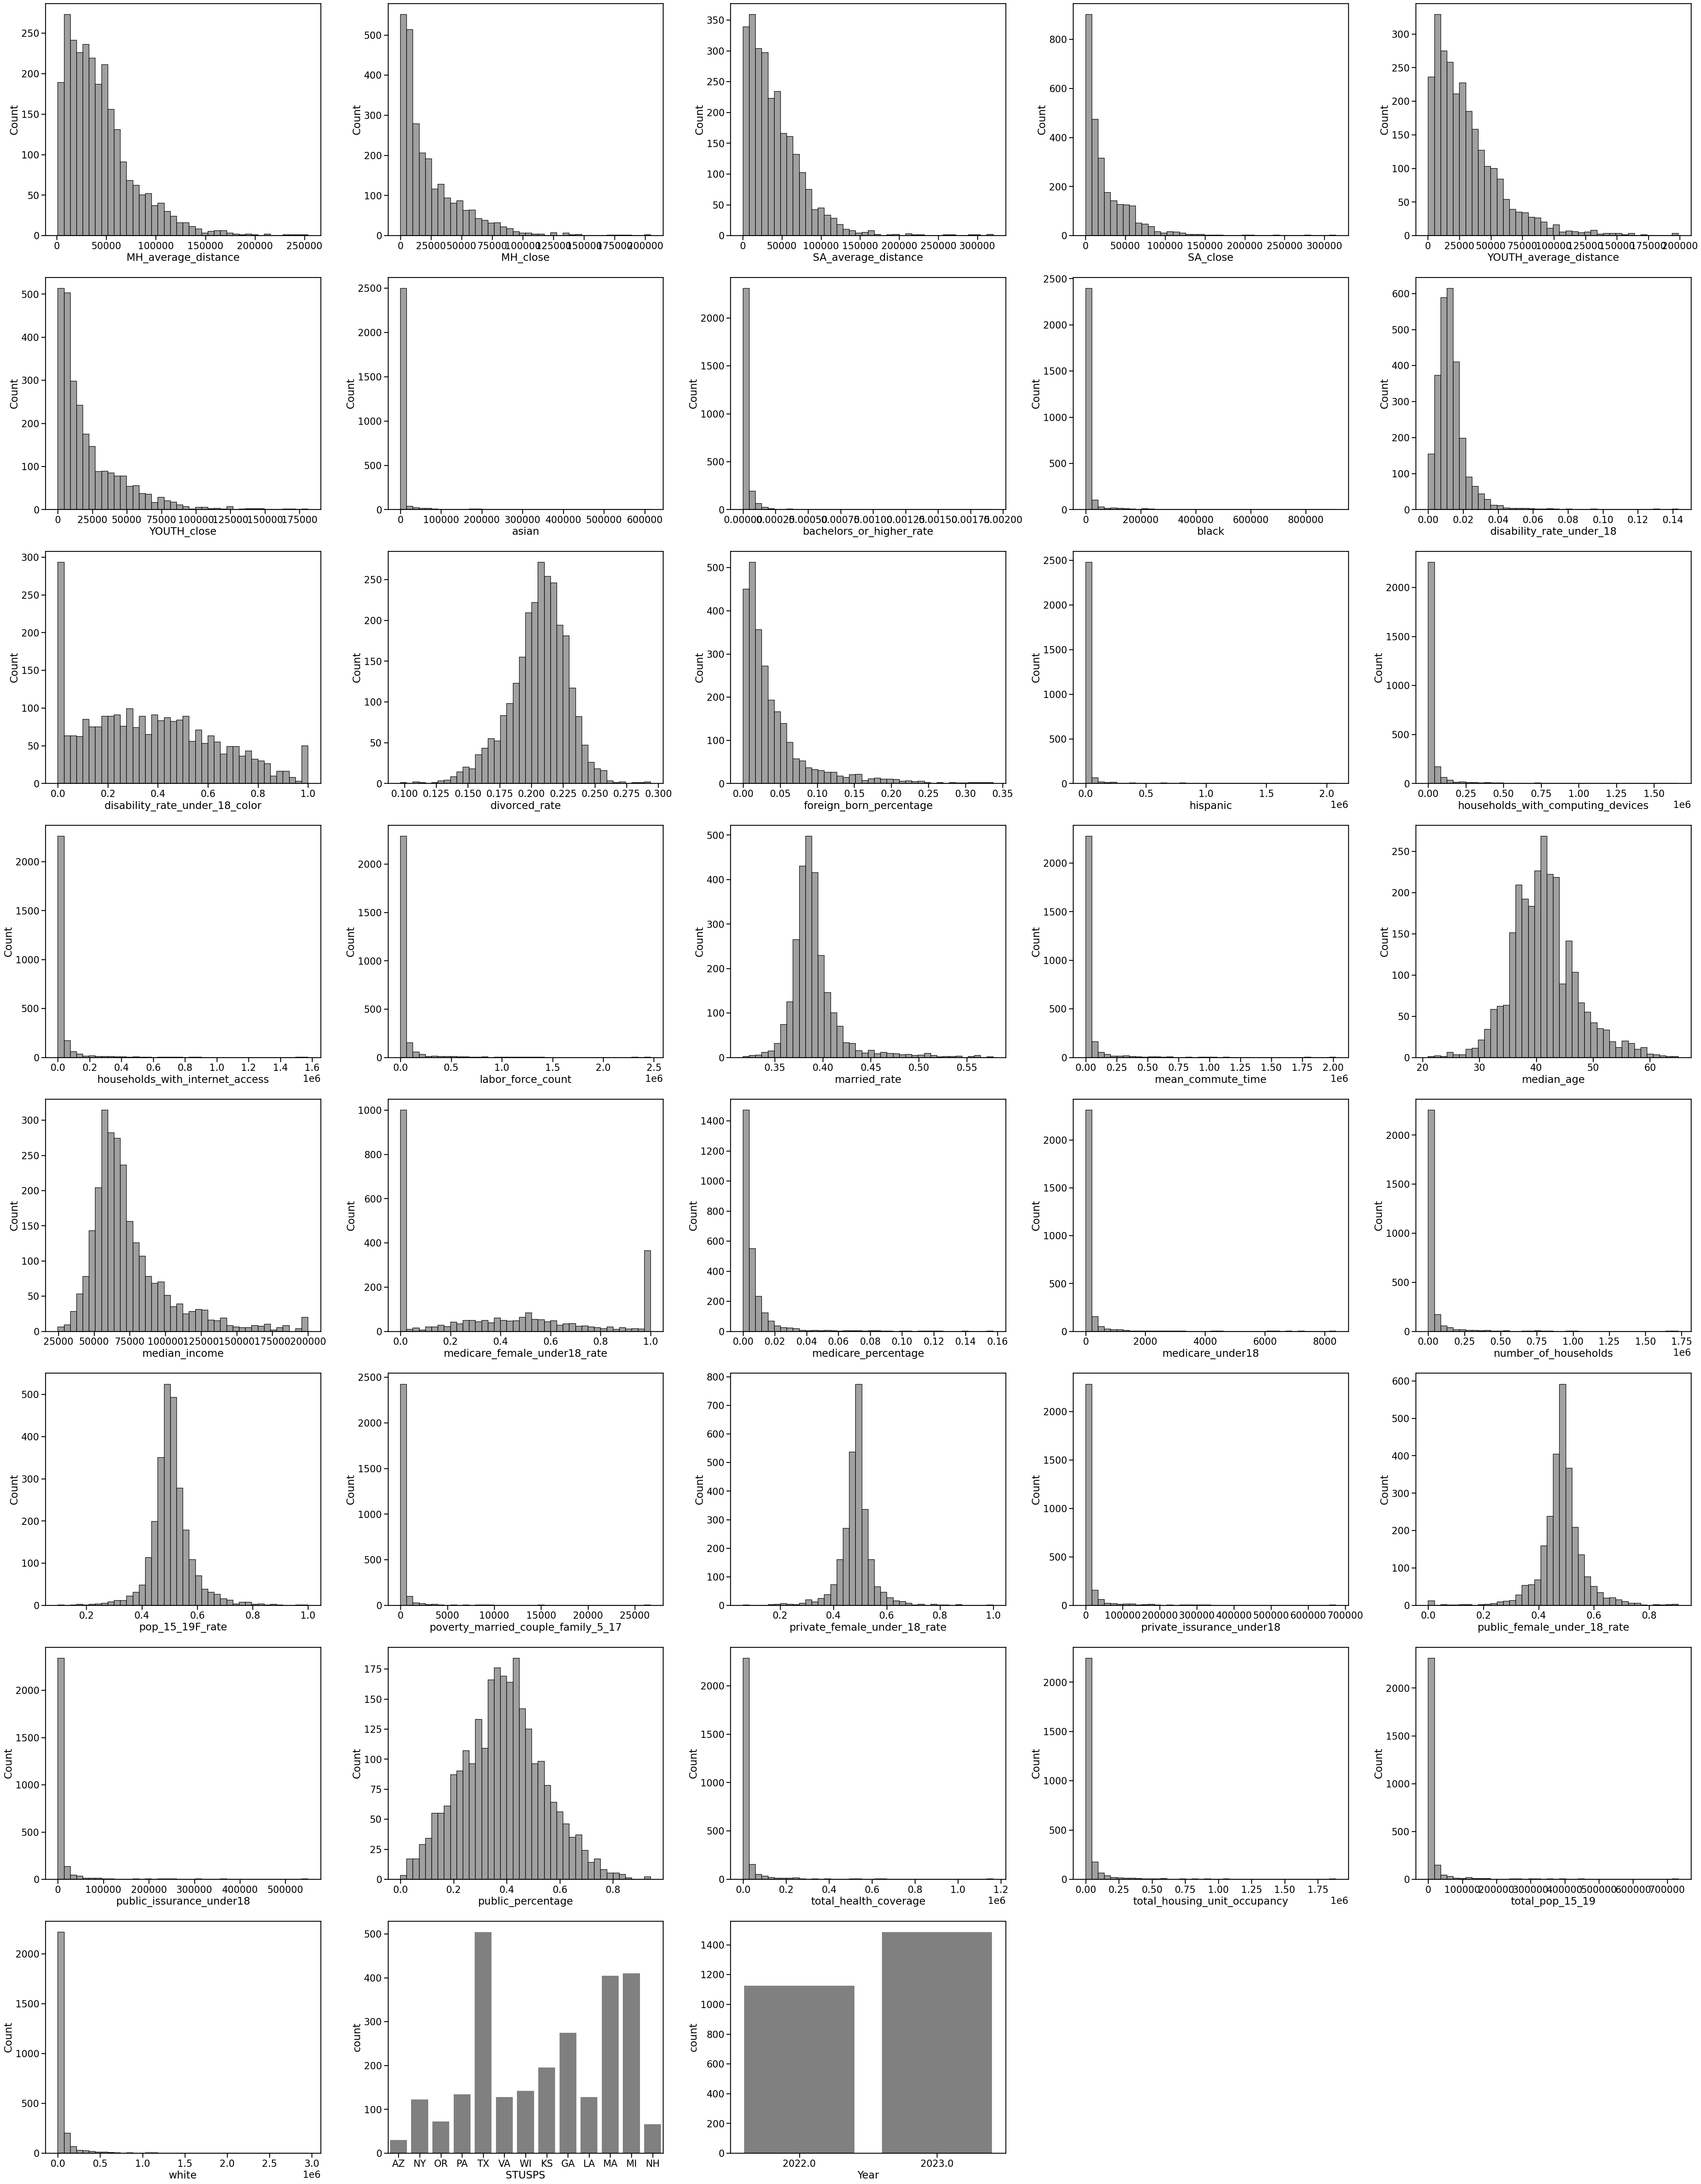

In [38]:
plot_feature_distributions(county_ses_vars[features], categorical_cols=['STUSPS','Year'], bins=40)

In [39]:
logged_features = ['MH_average_distance', 'MH_close','SA_close', 'SA_average_distance','YOUTH_close','YOUTH_average_distance',
                   'asian','black','bachelors_or_higher_rate','disability_rate_under_18','foreign_born_percentage', 'hispanic','households_with_computing_devices',
                   'households_with_internet_access','labor_force_count','mean_commute_time', 'medicare_percentage','medicare_under18','number_of_households','poverty_married_couple_family_5_17',
                   'private_issurance_under18', 'public_issurance_under18','total_health_coverage','total_housing_unit_occupancy','total_pop_15_19','white']

In [40]:
def transform_to_log(logged_features, df):
    for f in logged_features:
        logged_col = f'log_{f}'
        df[logged_col] = np.log10(df[f]+1)
    return df

In [41]:
county_ses_vars = transform_to_log(logged_features, county_ses_vars)
county_ses_vars

,STATEFP,COUNTYF,COUNTYN,GEOIDFQ,GEOID,NAME,NAMELSA,STUSPS,STATE_N,LSAD,...,log_medicare_percentage,log_medicare_under18,log_number_of_households,log_poverty_married_couple_family_5_17,log_private_issurance_under18,log_public_issurance_under18,log_total_health_coverage,log_total_housing_unit_occupancy,log_total_pop_15_19,log_white
0,04,009,00025444,0500000US04009,04009,Graham,Graham County,AZ,Arizona,06,...,0.004589,2.089905,4.095553,1.681241,3.814514,3.685921,4.060615,4.144325,3.712650,4.410609
1,04,009,00025444,0500000US04009,04009,Graham,Graham County,AZ,Arizona,06,...,0.005349,2.158362,4.079868,1.929419,3.811374,3.692759,4.062537,4.138492,3.724685,4.420781
2,36,013,00974105,0500000US36013,36013,Chautauqua,Chautauqua County,NY,New York,06,...,0.002607,2.238046,4.727590,2.505150,4.173099,4.131041,4.456227,4.821847,4.165719,5.053727
3,36,013,00974105,0500000US36013,36013,Chautauqua,Chautauqua County,NY,New York,06,...,0.002118,2.152288,4.729189,2.491362,4.170819,4.143390,4.460474,4.821703,4.159116,5.042556
4,36,045,00974121,0500000US36045,36045,Jefferson,Jefferson County,NY,New York,06,...,0.001032,1.857332,4.663701,2.636488,4.297126,4.000174,4.475611,4.789397,4.222482,4.994963
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2604,33,None,None,None,3307115,Wilton-Lyndeborough School District,None,NH,None,00,...,0.000075,0.001561,3.358861,0.000564,2.815087,2.443851,2.968979,3.392473,2.808814,3.709430
2605,33,None,None,None,3307170,Windham School District,None,NH,None,00,...,0.000012,0.000000,3.737212,0.000954,3.621982,2.206135,3.638338,3.760375,3.286340,4.124287
2606,33,None,None,None,3307200,Windsor School District,None,NH,None,00,...,0.001776,0.000000,1.945665,0.000000,0.795845,1.400443,1.494740,2.110627,1.153845,2.294409
2607,33,None,None,None,3307300,Winnisquam Regional School District,None,NH,None,00,...,0.000026,0.002943,3.659291,0.012879,3.201838,2.934098,3.389294,3.745960,3.200094,4.051471


In [42]:
county_ses_vars[county_ses_vars['NAME'] == 'Rivendell Interstate School District']['log_medicare_under18']

2608    0.0
Name: log_medicare_under18, dtype: float64

In [43]:
logged_features

['MH_average_distance',
 'MH_close',
 'SA_close',
 'SA_average_distance',
 'YOUTH_close',
 'YOUTH_average_distance',
 'asian',
 'black',
 'bachelors_or_higher_rate',
 'disability_rate_under_18',
 'foreign_born_percentage',
 'hispanic',
 'households_with_computing_devices',
 'households_with_internet_access',
 'labor_force_count',
 'mean_commute_time',
 'medicare_percentage',
 'medicare_under18',
 'number_of_households',
 'poverty_married_couple_family_5_17',
 'private_issurance_under18',
 'public_issurance_under18',
 'total_health_coverage',
 'total_housing_unit_occupancy',
 'total_pop_15_19',
 'white']

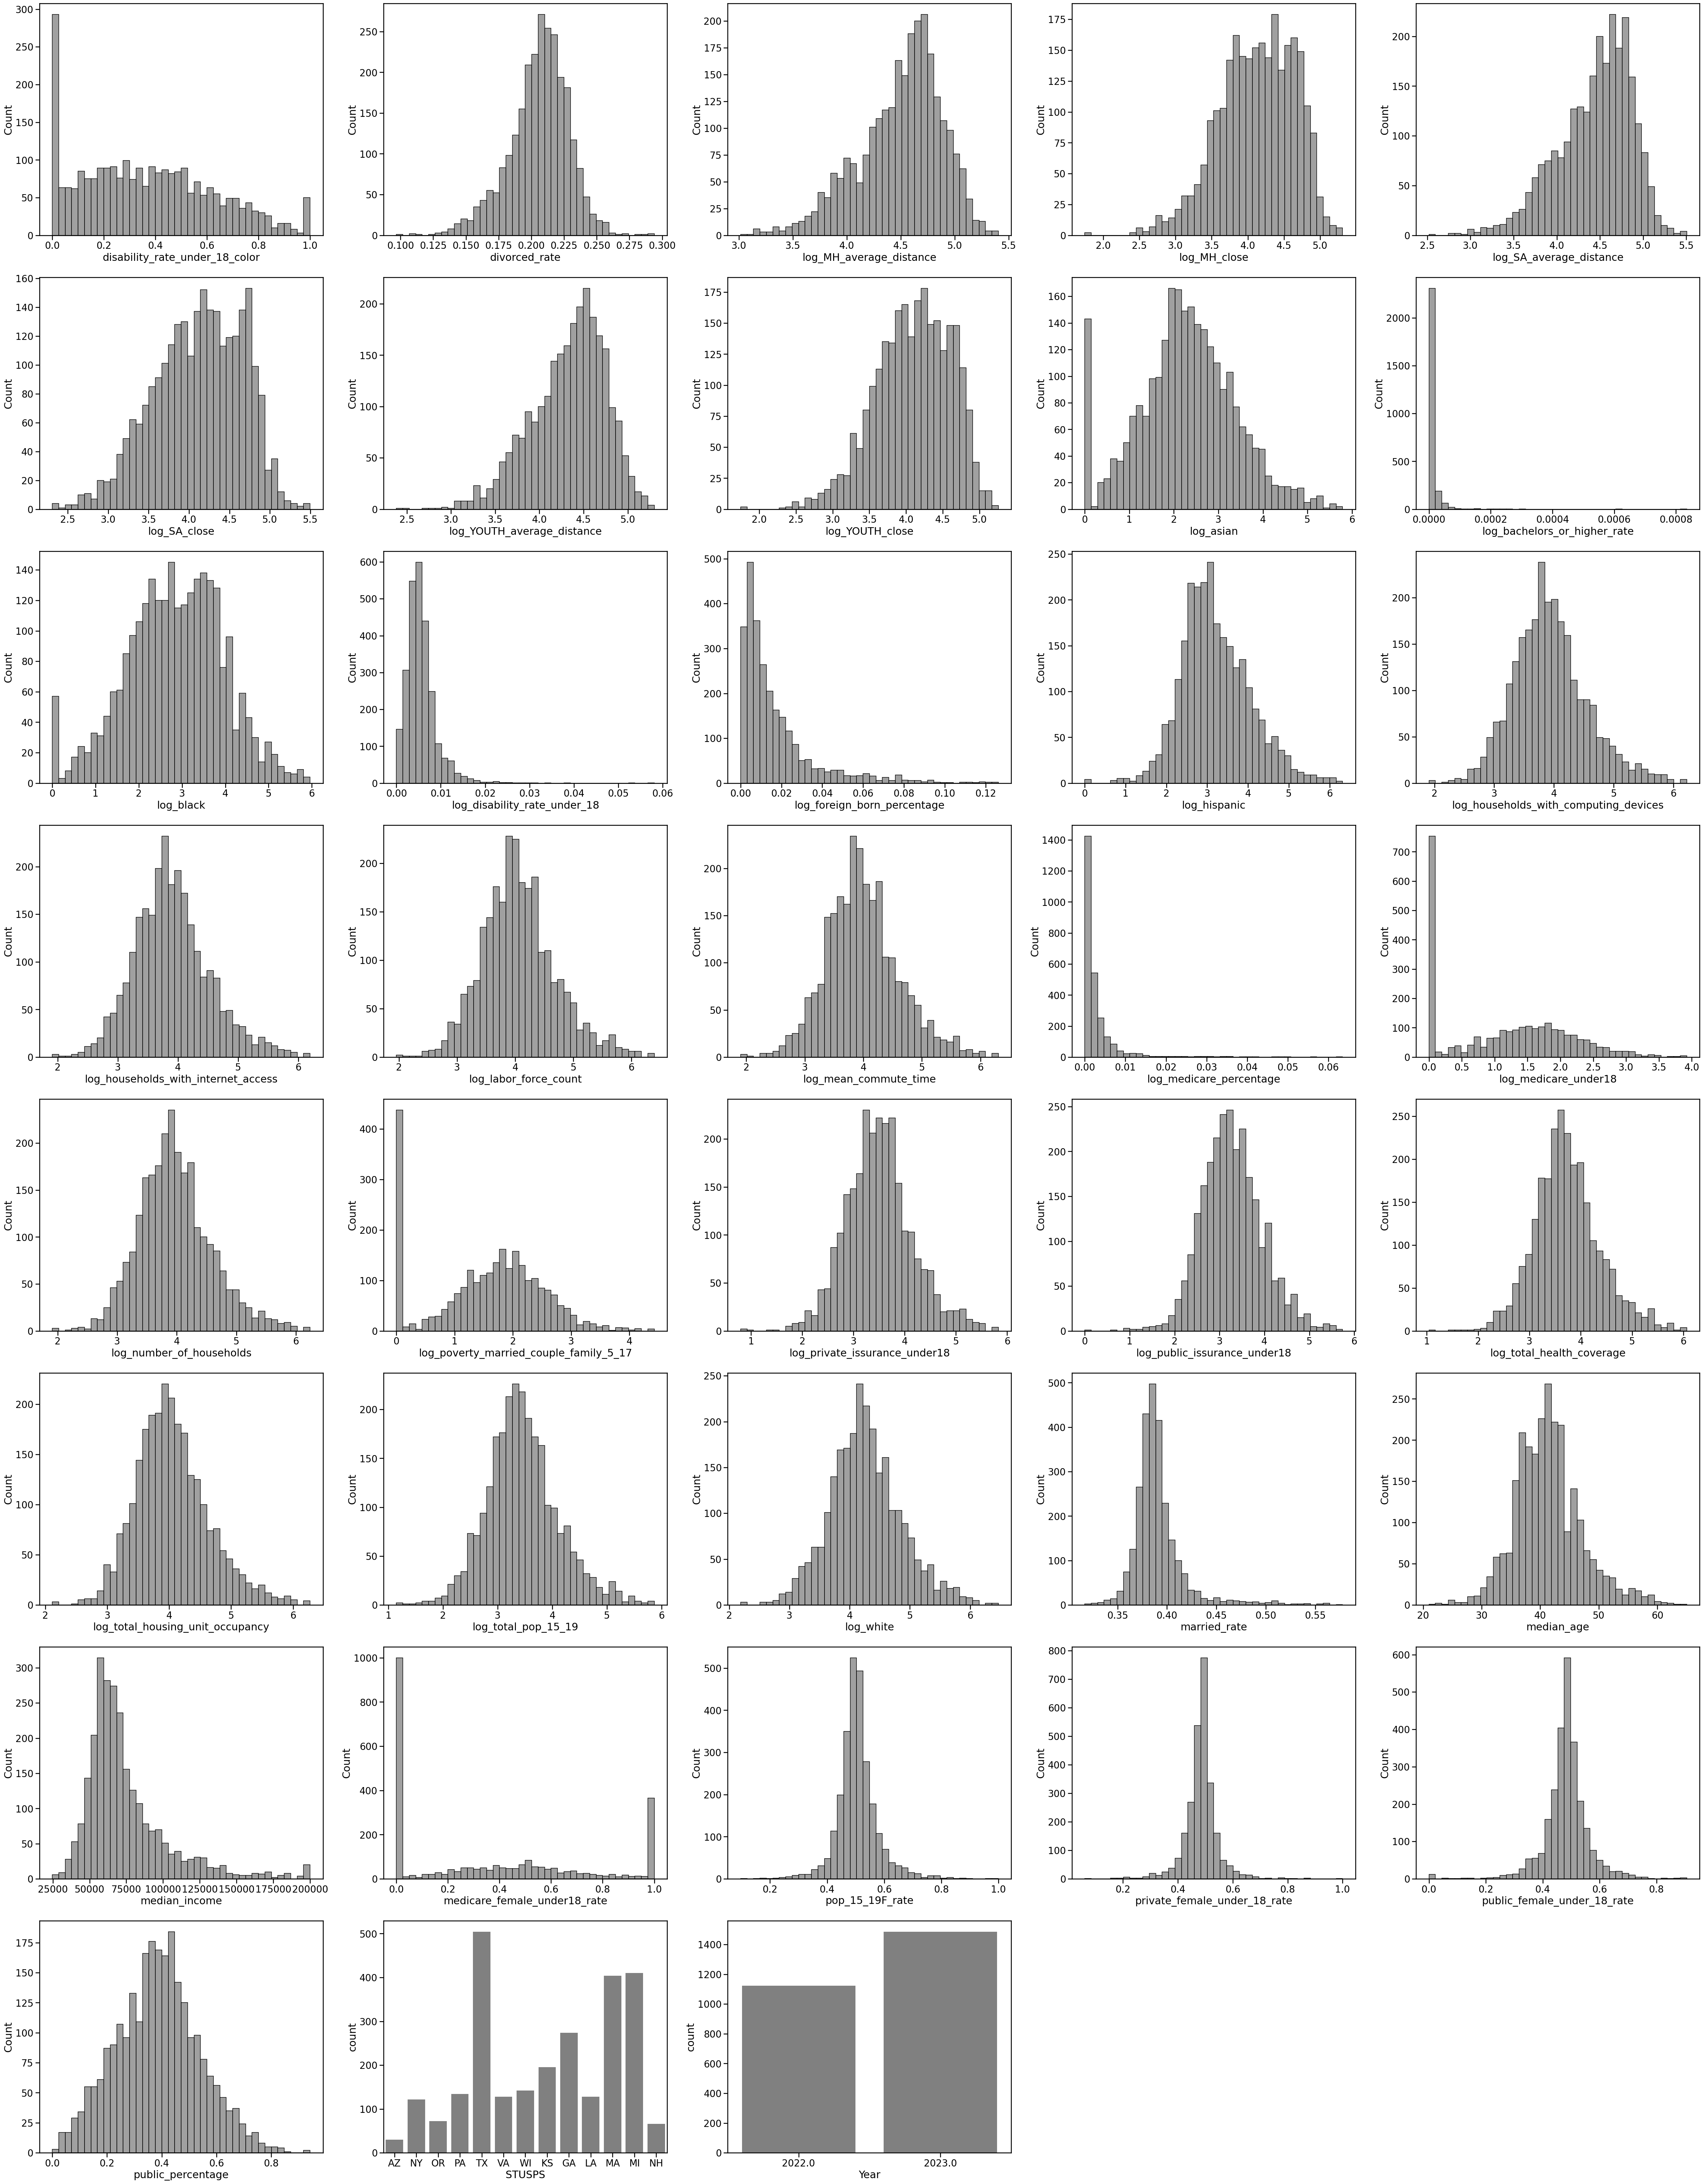

In [44]:
transformed_features = [f for f in features if f not in logged_features]
log_cols = county_ses_vars.columns[county_ses_vars.columns.str.startswith('log_')]
transformed_features.extend(log_cols)
plot_feature_distributions(county_ses_vars[transformed_features], categorical_cols=['STUSPS','Year'], bins=40)

#### Split the dataset

In [45]:
county_ses_vars

,STATEFP,COUNTYF,COUNTYN,GEOIDFQ,GEOID,NAME,NAMELSA,STUSPS,STATE_N,LSAD,...,log_medicare_percentage,log_medicare_under18,log_number_of_households,log_poverty_married_couple_family_5_17,log_private_issurance_under18,log_public_issurance_under18,log_total_health_coverage,log_total_housing_unit_occupancy,log_total_pop_15_19,log_white
0,04,009,00025444,0500000US04009,04009,Graham,Graham County,AZ,Arizona,06,...,0.004589,2.089905,4.095553,1.681241,3.814514,3.685921,4.060615,4.144325,3.712650,4.410609
1,04,009,00025444,0500000US04009,04009,Graham,Graham County,AZ,Arizona,06,...,0.005349,2.158362,4.079868,1.929419,3.811374,3.692759,4.062537,4.138492,3.724685,4.420781
2,36,013,00974105,0500000US36013,36013,Chautauqua,Chautauqua County,NY,New York,06,...,0.002607,2.238046,4.727590,2.505150,4.173099,4.131041,4.456227,4.821847,4.165719,5.053727
3,36,013,00974105,0500000US36013,36013,Chautauqua,Chautauqua County,NY,New York,06,...,0.002118,2.152288,4.729189,2.491362,4.170819,4.143390,4.460474,4.821703,4.159116,5.042556
4,36,045,00974121,0500000US36045,36045,Jefferson,Jefferson County,NY,New York,06,...,0.001032,1.857332,4.663701,2.636488,4.297126,4.000174,4.475611,4.789397,4.222482,4.994963
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2604,33,None,None,None,3307115,Wilton-Lyndeborough School District,None,NH,None,00,...,0.000075,0.001561,3.358861,0.000564,2.815087,2.443851,2.968979,3.392473,2.808814,3.709430
2605,33,None,None,None,3307170,Windham School District,None,NH,None,00,...,0.000012,0.000000,3.737212,0.000954,3.621982,2.206135,3.638338,3.760375,3.286340,4.124287
2606,33,None,None,None,3307200,Windsor School District,None,NH,None,00,...,0.001776,0.000000,1.945665,0.000000,0.795845,1.400443,1.494740,2.110627,1.153845,2.294409
2607,33,None,None,None,3307300,Winnisquam Regional School District,None,NH,None,00,...,0.000026,0.002943,3.659291,0.012879,3.201838,2.934098,3.389294,3.745960,3.200094,4.051471


In [46]:
county_ses_vars[county_ses_vars['Year'] == 2023][transformed_features]

,STUSPS,Year,median_age,median_income,public_percentage,public_female_under_18_rate,private_female_under_18_rate,medicare_female_under18_rate,disability_rate_under_18_color,pop_15_19F_rate,...,log_medicare_percentage,log_medicare_under18,log_number_of_households,log_poverty_married_couple_family_5_17,log_private_issurance_under18,log_public_issurance_under18,log_total_health_coverage,log_total_housing_unit_occupancy,log_total_pop_15_19,log_white
0,AZ,2023.0,34.400000,67326.000000,0.421968,0.448155,0.495324,0.229508,0.476289,0.452995,...,0.004589,2.089905,4.095553,1.681241,3.814514,3.685921,4.060615,4.144325,3.712650,4.410609
3,NY,2023.0,42.700000,56507.000000,0.481847,0.489756,0.488595,0.482270,0.365829,0.493899,...,0.002118,2.152288,4.729189,2.491362,4.170819,4.143390,4.460474,4.821703,4.159116,5.042556
5,NY,2023.0,33.200000,64978.000000,0.351036,0.503517,0.488575,0.186441,0.177301,0.468641,...,0.000868,1.778151,4.669335,2.711807,4.281624,4.016114,4.470746,4.790440,4.214208,4.985620
7,NY,2023.0,41.800000,143408.000000,0.201513,0.475294,0.487899,0.406548,0.552313,0.507339,...,0.001936,3.166430,5.659038,3.215638,5.415981,4.820458,5.516150,5.679302,5.210442,5.915958
9,OR,2023.0,57.200000,64769.000000,0.690153,0.497326,0.482553,0.000000,0.114943,0.465347,...,0.000023,0.000000,4.052348,1.431364,3.070407,3.418135,3.579194,4.118066,3.305566,4.306253
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2604,NH,2023.0,46.208325,107582.595402,0.297945,0.631588,0.532028,1.000000,0.839708,0.480569,...,0.000075,0.001561,3.358861,0.000564,2.815087,2.443851,2.968979,3.392473,2.808814,3.709430
2605,NH,2023.0,40.144937,182102.643031,0.036779,0.358820,0.464615,0.000000,0.000260,0.665138,...,0.000012,0.000000,3.737212,0.000954,3.621982,2.206135,3.638338,3.760375,3.286340,4.124287
2606,NH,2023.0,42.240039,92749.881520,0.807260,0.726335,0.678065,0.000000,0.000000,0.650479,...,0.001776,0.000000,1.945665,0.000000,0.795845,1.400443,1.494740,2.110627,1.153845,2.294409
2607,NH,2023.0,43.682519,85633.820316,0.350430,0.445424,0.540675,1.000000,0.167095,0.425846,...,0.000026,0.002943,3.659291,0.012879,3.201838,2.934098,3.389294,3.745960,3.200094,4.051471


In [47]:
county_ses_vars[county_ses_vars['Year'] == 2022][transformed_features]

,STUSPS,Year,median_age,median_income,public_percentage,public_female_under_18_rate,private_female_under_18_rate,medicare_female_under18_rate,disability_rate_under_18_color,pop_15_19F_rate,...,log_medicare_percentage,log_medicare_under18,log_number_of_households,log_poverty_married_couple_family_5_17,log_private_issurance_under18,log_public_issurance_under18,log_total_health_coverage,log_total_housing_unit_occupancy,log_total_pop_15_19,log_white
1,AZ,2022.0,34.100000,64089.000000,0.426774,0.457792,0.491353,0.321678,0.448837,0.479638,...,0.005349,2.158362,4.079868,1.929419,3.811374,3.692759,4.062537,4.138492,3.724685,4.420781
2,NY,2022.0,42.800000,54625.000000,0.472941,0.476962,0.492347,0.738372,0.349184,0.505155,...,0.002607,2.238046,4.727590,2.505150,4.173099,4.131041,4.456227,4.821847,4.165719,5.053727
4,NY,2022.0,32.800000,62782.000000,0.334615,0.498151,0.488951,0.211268,0.303128,0.475135,...,0.001032,1.857332,4.663701,2.636488,4.297126,4.000174,4.475611,4.789397,4.222482,4.994963
6,NY,2022.0,41.700000,137709.000000,0.195180,0.479437,0.486423,0.528205,0.518832,0.511302,...,0.001560,3.068557,5.657794,3.224274,5.415833,4.802521,5.512081,5.678503,5.211782,5.935222
8,OR,2022.0,56.800000,64300.000000,0.590673,0.573014,0.429212,0.000000,0.385965,0.470821,...,0.000023,0.000000,4.047236,1.681241,3.193681,3.352954,3.581591,4.115810,3.305996,4.312643
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1919,MA,2022.0,45.229008,83633.675258,0.410881,0.445682,0.610751,0.000000,0.000000,0.554834,...,0.000019,0.000000,3.559580,0.000000,3.188842,3.032532,3.418684,3.608332,3.141990,3.954300
1920,MA,2022.0,41.822790,200000.000000,0.042540,0.496462,0.530155,0.697674,0.192593,0.618011,...,0.000011,0.020071,3.907380,1.002123,3.794560,2.443558,3.813496,3.914616,3.413781,4.232957
1921,MA,2022.0,42.085783,107225.809884,0.182906,0.458740,0.556252,0.539708,0.291479,0.558570,...,0.000024,0.026002,3.921066,0.061829,3.457253,2.807696,3.545064,3.950349,3.472254,4.176236
1922,MA,2022.0,37.041107,109447.044683,0.297485,0.510950,0.503183,0.697722,0.220771,0.446357,...,0.002138,1.642712,4.206857,1.715345,3.784294,3.414258,3.940715,4.225470,3.768345,4.493703


In [48]:
county_ses_vars.shape

(2609, 171)

In [49]:
county_ses_vars['dropout_rate'].isna().sum()

np.int64(297)

In [210]:
lr_rmse = lr_rmse_2022 = lr_rmse_2023 =  lr_r2 = lr_r2_2022 = lr_r2_2023 =  []
    
en_rmse = en_rmse_2022 = en_rmse_2023 = en_r2 = en_r2_2022 = en_r2_2023 =  []
dtr_rmse = dtr_rmse_2022 = dtr_rmse_2023 = dtr_r2 = dtr_r2_2022 = dtr_r2_2023 = []
rf_rmse = rf_rmse_2022 = rf_rmse_2023 = rf_r2 = rf_r2_2022 = rf_r2_2023 =  []
gbr_rmse = gbr_rmse_2022 = gbr_rmse_2023 = gbr_r2 = gbr_r2_2022 = gbr_r2_2023 = []

In [61]:
def models_predict(X_train, y_train, X_test, y_test):
    linear_regressor = LinearRegression().fit(X = X_train, y = y_train)
    lr_y_pred = linear_regressor.predict(X_test)

    elastic_net = ElasticNet(random_state=42).fit(X = X_train, y = y_train)
    en_y_pred = elastic_net.predict(X_test)

    dt_regressor = DecisionTreeRegressor(random_state=42).fit(X = X_train, y = y_train)
    dtr_y_pred = dt_regressor.predict(X_test)

    rf_regressor = RandomForestRegressor(random_state=42).fit(X = X_train, y = y_train)
    rf_y_pred = rf_regressor.predict(X_test)

    gradient_boosting_regressor = GradientBoostingRegressor(random_state=42).fit(X = X_train, y = y_train)
    gbr_y_pred = gradient_boosting_regressor.predict(X_test)
    
    return lr_y_pred, en_y_pred, dtr_y_pred, rf_y_pred, gbr_y_pred





In [247]:
def get_model_scores(models_scores, n_splits):
    # scores_stats = {model:{} for model in models_scores.keys()}
    # for model in models_scores.keys():
    #     scores_stats[model]['R2_avg'] = sum(models_scores[model]['R2'])/len(models_scores[model]['R2'])
    #     scores_stats[model]['R2_sem'] = stats.sem(models_scores[model]['R2'])

    #     scores_stats[model]['RMSE_avg'] = sum(models_scores[model]['RMSE'])/len(models_scores[model]['RMSE'])
    #     scores_stats[model]['RMSE_sem'] = stats.sem(models_scores[model]['RMSE'])

    #     # models_scores[model]['R2'] = models_scores[model]['R2']/n_splits
    #     # models_scores[model]['RMSE'] = models_scores[model]['RMSE']/n_splits

    # models_scores_df = pd.DataFrame(models_scores)
    # print(models_scores_df)

    rows = []
    for model, metrics in models_scores.items():
        for r2, rmse in zip(metrics['R2'], metrics['RMSE']):
            rows.append({
                "Model": model,
                "R2": r2,
                "RMSE": rmse
            })

    # Create DataFrame
    models_scores_df = pd.DataFrame(rows)
    print(models_scores_df)
    return models_scores_df

In [75]:
county_ses_vars.iloc[9:11][['Year']].index.tolist()

[9, 10]

In [255]:
def ml_train_test(data, feature_ls, target = 'dropout_rate', year = 'both', n_splits = 5 ):
    sgkf = StratifiedKFold(n_splits= n_splits, random_state=42, shuffle=True)
    # sgkf = StratifiedGroupKFold(n_splits=5, random_state=42, shuffle=True)
    # sgkf = StratifiedShuffleSplit(n_splits=5, test_size= 0.2, random_state=42)
    features = feature_ls.copy()
    onehot_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
    encoded_features = onehot_encoder.fit_transform(data[['STUSPS', 'Year']])
    encoded_df = pd.DataFrame(encoded_features, columns=onehot_encoder.get_feature_names_out(['STUSPS','Year']), index=data.index)
    data_encoded = pd.concat([data, encoded_df], axis=1)
    features.extend(encoded_df.columns.tolist())
    features.remove('STUSPS')
    features.remove('Year')

    if year == 'both':
        X = data_encoded[features]
        groups = data_encoded['STUSPS']
        y = data_encoded[target]
        
    elif year == '2022':
        features.remove('Year_2022.0')
        features.remove('Year_2023.0')
        X = data_encoded[data_encoded['Year'] == 2022][features]
        groups = data_encoded[data_encoded['Year'] == 2022]['STUSPS']
        y = data_encoded[data_encoded['Year'] == 2022][target]
    elif year == '2023':
        features.remove('Year_2022.0')
        features.remove('Year_2023.0')
        X = data_encoded[data_encoded['Year'] == 2023][features]
        y = data_encoded[data_encoded['Year'] == 2023][target]
        groups = data_encoded[data_encoded['Year'] == 2023]['STUSPS']

    

    lr_rmse = lr_rmse_2022 = lr_rmse_2023 =  lr_r2 = lr_r2_2022 = lr_r2_2023 =  0.0
    en_rmse = en_rmse_2022 = en_rmse_2023 = en_r2 = en_r2_2022 = en_r2_2023 =  0.0
    dtr_rmse = dtr_rmse_2022 = dtr_rmse_2023 = dtr_r2 = dtr_r2_2022 = dtr_r2_2023 = 0.0
    rf_rmse = rf_rmse_2022 = rf_rmse_2023 = rf_r2 = rf_r2_2022 = rf_r2_2023 =  0.0
    gbr_rmse = gbr_rmse_2022 = gbr_rmse_2023 = gbr_r2 = gbr_r2_2022 = gbr_r2_2023 = 0.0

    lr_rmse = []
    lr_rmse_2022 = []
    lr_rmse_2023 = []

    lr_r2 = []
    lr_r2_2022 = []
    lr_r2_2023 = []

    en_rmse = []
    en_rmse_2022 = []
    en_rmse_2023 = []

    en_r2 = []
    en_r2_2022 = []
    en_r2_2023 = []

    dtr_rmse = []
    dtr_rmse_2022 = []
    dtr_rmse_2023 = []

    dtr_r2 = []
    dtr_r2_2022 = []
    dtr_r2_2023 = []

    rf_rmse = []
    rf_rmse_2022 = []
    rf_rmse_2023 = []

    rf_r2 = []
    rf_r2_2022 = []
    rf_r2_2023 = []

    gbr_rmse = []
    gbr_rmse_2022 = []
    gbr_rmse_2023 = []

    gbr_r2 = []
    gbr_r2_2022 = []
    gbr_r2_2023 = []




    predictions_kfold = {"LinearRegression": [], "ElasticNet":[], 'DecisionTreeRegressor':[], 'RandomForestRegressor':[],
                         'GradientBoostingRegressor':[]}
    
    for i, (train_index, test_index) in enumerate(sgkf.split(X, groups)):
        # print(f"Fold {i}:")

        X_train = X.iloc[train_index]
        y_train = y.iloc[train_index]
        # print(X_train)
        
        X_test = X.iloc[test_index]
        y_test = y.iloc[test_index]
        test_df = data_encoded.iloc[test_index]
        test_idx_2022 = test_df[test_df['Year'] == 2022].index.tolist()
        test_idx_2023 = test_df[test_df['Year'] == 2023].index.tolist()
        # print(X_train.groupby("STUSPS").size()/len(X_train))
        # print(X_test.groupby("STUSPS").size()/len(X_test))
        lr_y_pred, en_y_pred, dtr_y_pred, rf_y_pred, gbr_y_pred = models_predict(X_train, y_train, X_test, y_test)
        predictions_kfold['LinearRegression'].append(lr_y_pred)
        predictions_kfold['ElasticNet'].append(en_y_pred)
        predictions_kfold['DecisionTreeRegressor'].append(dtr_y_pred)
        predictions_kfold['RandomForestRegressor'].append(rf_y_pred)
        predictions_kfold['GradientBoostingRegressor'].append(gbr_y_pred)

        true_pred_df = pd.DataFrame()
        true_pred_df.index = y_test.index
        true_pred_df['true'] = y_test
        true_pred_df['LinearRegression'] = lr_y_pred
        true_pred_df['ElasticNet'] = en_y_pred
        true_pred_df['DecisionTreeRegressor'] = dtr_y_pred
        true_pred_df['RandomForestRegressor'] = rf_y_pred
        true_pred_df['GradientBoostingRegressor'] = gbr_y_pred
        
        # lr_rmse += mean_squared_error(y_test, lr_y_pred) ** 0.5
        # lr_r2 += r2_score(y_test, lr_y_pred)

        lr_rmse.append(mean_squared_error(y_test, lr_y_pred) ** 0.5)
        lr_r2.append(r2_score(y_test, lr_y_pred))

        # lr_rmse_2022 += mean_squared_error(y.iloc[test_idx_2022], true_pred_df.loc[test_idx_2022,'LinearRegression']) ** 0.5
        # lr_r2_2022 += r2_score(y.iloc[test_idx_2022], true_pred_df.loc[test_idx_2022,'LinearRegression'])

        lr_rmse_2022.append(mean_squared_error(y.iloc[test_idx_2022], true_pred_df.loc[test_idx_2022,'LinearRegression']) ** 0.5)
        lr_r2_2022.append(r2_score(y.iloc[test_idx_2022], true_pred_df.loc[test_idx_2022,'LinearRegression']))


        # lr_rmse_2023 += mean_squared_error(y.iloc[test_idx_2023], true_pred_df.loc[test_idx_2023,'LinearRegression']) ** 0.5
        # lr_r2_2023 += r2_score(y.iloc[test_idx_2023], true_pred_df.loc[test_idx_2023,'LinearRegression'])

        lr_rmse_2023.append(mean_squared_error(y.iloc[test_idx_2023], true_pred_df.loc[test_idx_2023,'LinearRegression']) ** 0.5)
        lr_r2_2023.append(r2_score(y.iloc[test_idx_2023], true_pred_df.loc[test_idx_2023,'LinearRegression']))

        # en_rmse += mean_squared_error(y_test, en_y_pred) ** 0.5
        # en_r2 += r2_score(y_test, en_y_pred)

        en_rmse.append(mean_squared_error(y_test, en_y_pred) ** 0.5)
        en_r2.append(r2_score(y_test, en_y_pred))

        # en_rmse_2022 += mean_squared_error(y.iloc[test_idx_2022], true_pred_df.loc[test_idx_2022,'ElasticNet'] ) ** 0.5
        # en_r2_2022 += r2_score(y.iloc[test_idx_2022], true_pred_df.loc[test_idx_2022,'ElasticNet'])

        en_rmse_2022.append(mean_squared_error(y.iloc[test_idx_2022], true_pred_df.loc[test_idx_2022,'ElasticNet'] ) ** 0.5)
        en_r2_2022.append(r2_score(y.iloc[test_idx_2022], true_pred_df.loc[test_idx_2022,'ElasticNet']))


        # en_rmse_2023 += mean_squared_error(y.iloc[test_idx_2023], true_pred_df.loc[test_idx_2023,'ElasticNet'] ) ** 0.5
        # en_r2_2023 += r2_score(y.iloc[test_idx_2023], true_pred_df.loc[test_idx_2023,'ElasticNet'])

        en_rmse_2023.append(mean_squared_error(y.iloc[test_idx_2023], true_pred_df.loc[test_idx_2023,'ElasticNet'] ) ** 0.5)
        en_r2_2023.append(r2_score(y.iloc[test_idx_2023], true_pred_df.loc[test_idx_2023,'ElasticNet']))

        # dtr_rmse += mean_squared_error(y_test, dtr_y_pred) ** 0.5
        # dtr_r2 += r2_score(y_test, dtr_y_pred)

        dtr_rmse.append(mean_squared_error(y_test, dtr_y_pred) ** 0.5)
        dtr_r2.append(r2_score(y_test, dtr_y_pred))

        # dtr_rmse_2022 += mean_squared_error(y.iloc[test_idx_2022], true_pred_df.loc[test_idx_2022,'DecisionTreeRegressor']) **0.5
        # dtr_r2_2022 += r2_score(y.iloc[test_idx_2022], true_pred_df.loc[test_idx_2022,'DecisionTreeRegressor'])

        dtr_rmse_2022.append(mean_squared_error(y.iloc[test_idx_2022], true_pred_df.loc[test_idx_2022,'DecisionTreeRegressor']) **0.5)
        dtr_r2_2022.append(r2_score(y.iloc[test_idx_2022], true_pred_df.loc[test_idx_2022,'DecisionTreeRegressor']))


        # dtr_rmse_2023 += mean_squared_error(y.iloc[test_idx_2023], true_pred_df.loc[test_idx_2023,'DecisionTreeRegressor']) **0.5
        # dtr_r2_2023 += r2_score(y.iloc[test_idx_2023], true_pred_df.loc[test_idx_2023,'DecisionTreeRegressor'])

        dtr_rmse_2023.append(mean_squared_error(y.iloc[test_idx_2023], true_pred_df.loc[test_idx_2023,'DecisionTreeRegressor']) **0.5)
        dtr_r2_2023.append(r2_score(y.iloc[test_idx_2023], true_pred_df.loc[test_idx_2023,'DecisionTreeRegressor']))

        # rf_rmse += mean_squared_error(y_test, rf_y_pred) ** 0.5
        # rf_r2 += r2_score(y_test, rf_y_pred)

        rf_rmse.append(mean_squared_error(y_test, rf_y_pred) ** 0.5)
        rf_r2.append(r2_score(y_test, rf_y_pred))

        # rf_rmse_2022 += mean_squared_error(y.iloc[test_idx_2022], true_pred_df.loc[test_idx_2022, 'RandomForestRegressor'] ) ** 0.5
        # rf_r2_2022 += r2_score(y.iloc[test_idx_2022], true_pred_df.loc[test_idx_2022, 'RandomForestRegressor'])

        rf_rmse_2022.append(mean_squared_error(y.iloc[test_idx_2022], true_pred_df.loc[test_idx_2022, 'RandomForestRegressor'] ) ** 0.5)
        rf_r2_2022.append(r2_score(y.iloc[test_idx_2022], true_pred_df.loc[test_idx_2022, 'RandomForestRegressor']))

        # rf_rmse_2023 += mean_squared_error(y.iloc[test_idx_2023], true_pred_df.loc[test_idx_2023, 'RandomForestRegressor'] ) ** 0.5
        # rf_r2_2023 += r2_score(y.iloc[test_idx_2023], true_pred_df.loc[test_idx_2023, 'RandomForestRegressor'])

        rf_rmse_2023.append(mean_squared_error(y.iloc[test_idx_2023], true_pred_df.loc[test_idx_2023, 'RandomForestRegressor'] ) ** 0.5)
        rf_r2_2023.append(r2_score(y.iloc[test_idx_2023], true_pred_df.loc[test_idx_2023, 'RandomForestRegressor']))

        # gbr_rmse += mean_squared_error(y_test, gbr_y_pred) ** 0.5
        # gbr_r2 += r2_score(y_test, gbr_y_pred)

        gbr_rmse.append(mean_squared_error(y_test, gbr_y_pred) ** 0.5)
        gbr_r2.append(r2_score(y_test, gbr_y_pred))

        # gbr_rmse_2022 += mean_squared_error(y.iloc[test_idx_2022], true_pred_df.loc[test_idx_2022, 'GradientBoostingRegressor'] ) ** 0.5
        # gbr_r2_2022 += r2_score(y.iloc[test_idx_2022], true_pred_df.loc[test_idx_2022, 'GradientBoostingRegressor'])

        gbr_rmse_2022.append(mean_squared_error(y.iloc[test_idx_2022], true_pred_df.loc[test_idx_2022, 'GradientBoostingRegressor'] ) ** 0.5)
        gbr_r2_2022.append(r2_score(y.iloc[test_idx_2022], true_pred_df.loc[test_idx_2022, 'GradientBoostingRegressor']))


        # gbr_rmse_2023 += mean_squared_error(y.iloc[test_idx_2023], true_pred_df.loc[test_idx_2023, 'GradientBoostingRegressor'] ) ** 0.5
        # gbr_r2_2023 += r2_score(y.iloc[test_idx_2023], true_pred_df.loc[test_idx_2023, 'GradientBoostingRegressor'])

        gbr_rmse_2023.append(mean_squared_error(y.iloc[test_idx_2023], true_pred_df.loc[test_idx_2023, 'GradientBoostingRegressor'] ) ** 0.5)
        gbr_r2_2023.append(r2_score(y.iloc[test_idx_2023], true_pred_df.loc[test_idx_2023, 'GradientBoostingRegressor']))

    
    models_scores_sum = {'LinearRegression': {'R2': lr_r2, 'RMSE': lr_rmse}, 'ElasticNet': {'R2': en_r2, 'RMSE': en_rmse}, 'DecisionTreeRegressor': {'R2': dtr_r2, 'RMSE': dtr_rmse}, 
                     'RandomForestRegressor': {'R2': rf_r2, "RMSE": rf_rmse}, "GradientBoostingRegressor": {"R2": gbr_r2, "RMSE": gbr_rmse} }
    
    models_scores_df = get_model_scores(models_scores_sum, n_splits)

    models_scores_sum_2022 = {'LinearRegression': {'R2': lr_r2_2022, 'RMSE': lr_rmse_2022}, 'ElasticNet': {'R2': en_r2_2022, 'RMSE': en_rmse_2022}, 'DecisionTreeRegressor': {'R2': dtr_r2_2022, 'RMSE': dtr_rmse_2022}, 
                     'RandomForestRegressor': {'R2': rf_r2_2022, "RMSE": rf_rmse_2022}, "GradientBoostingRegressor": {"R2": gbr_r2_2022, "RMSE": gbr_rmse_2022} }

    models_scores_2022_df = get_model_scores(models_scores_sum_2022, n_splits)

    models_scores_sum_2023 = {'LinearRegression': {'R2': lr_r2_2023, 'RMSE': lr_rmse_2023}, 'ElasticNet': {'R2': en_r2_2023, 'RMSE': en_rmse_2023}, 'DecisionTreeRegressor': {'R2': dtr_r2_2023, 'RMSE': dtr_rmse_2023}, 
                     'RandomForestRegressor': {'R2': rf_r2_2023, "RMSE": rf_rmse_2023}, "GradientBoostingRegressor": {"R2": gbr_r2_2023, "RMSE": gbr_rmse_2023} }

    models_scores_2023_df = get_model_scores(models_scores_sum_2023, n_splits)

    r2_score_df = models_scores_df[['Model','R2']]
    r2_score_df.rename(columns={'R2':'R2_overall'}, inplace=True)
    r2_score_df = pd.concat([r2_score_df, models_scores_2022_df[['R2']] ], axis=1)
    r2_score_df.rename(columns={'R2':'R2_2022'}, inplace=True)
    r2_score_df = pd.concat([r2_score_df, models_scores_2023_df[['R2']] ], axis=1)
    r2_score_df.rename(columns={'R2':'R2_2023'}, inplace=True)

    rmse_score_df = models_scores_df[['Model','RMSE']]
    rmse_score_df.rename(columns={'RMSE':'RMSE_overall'}, inplace=True)
    rmse_score_df = pd.concat([rmse_score_df, models_scores_2022_df[['RMSE']] ], axis=1)
    rmse_score_df.rename(columns={'RMSE':'RMSE_2022'}, inplace=True)
    rmse_score_df = pd.concat([rmse_score_df, models_scores_2023_df[['RMSE']] ], axis=1)
    rmse_score_df.rename(columns={'RMSE':'RMSE_2023'}, inplace=True)




    # r2_score_df = models_scores_df[['R2_avg', 'R2_sem']]
    # r2_score_df.rename(columns={'R2_avg':'R2_avg_overall',  'R2_sem': 'R2_sem_overall'}, inplace=True)
    # r2_score_df = pd.concat([r2_score_df, models_scores_2022_df[['R2_avg', 'R2_sem']] ], axis=1)
    # r2_score_df.rename(columns={'R2_avg':'R2_avg_2022', 'R2_sem': 'R2_sem_2022'}, inplace=True)
    # r2_score_df = pd.concat([r2_score_df, models_scores_2023_df[['R2_avg', 'R2_sem']] ], axis=1)
    # r2_score_df.rename(columns={'R2_avg':'R2_avg_2023', 'R2_sem': 'R2_sem_2023'}, inplace=True)

    # rmse_score_df = models_scores_df[['RMSE_avg','RMSE_sem']]
    # rmse_score_df.rename(columns={'RMSE_avg':'RMSE_avg_overall', 'RMSE_sem': 'RMSE_sem_overall'}, inplace=True)
    # rmse_score_df = pd.concat([rmse_score_df, models_scores_2022_df[['RMSE_avg', 'RMSE_sem']] ], axis=1)
    # rmse_score_df.rename(columns={'RMSE_avg':'RMSE_avg_2022', 'RMSE_sem': 'RMSE_sem_2022'}, inplace=True)
    # rmse_score_df = pd.concat([rmse_score_df, models_scores_2023_df[['RMSE_avg','RMSE_sem']] ], axis=1)
    # rmse_score_df.rename(columns={'RMSE_avg':'RMSE_avg_2023', 'RMSE_sem': 'RMSE_sem_2023'}, inplace=True)


    return models_scores_df, models_scores_2022_df, models_scores_2023_df, r2_score_df, rmse_score_df


        

              


In [ ]:
county_ses_vars_dropout_train = county_ses_vars[county_ses_vars['dropout_rate'].notna()].reset_index(drop=True)
models_scores_overall, models_scores_2022, models_scores_2023, r2_score_df, rmse_score_df = ml_train_test(county_ses_vars_dropout_train, transformed_features, target = 'dropout_rate', year = 'both' )
models_scores_overall

In [291]:
year_map = {
    "RMSE_overall": "2 school years",
    "RMSE_2022": "2021-2022",
    "RMSE_2023": "2022-2023"
}

rmse_score_long = (
    rmse_score_df.melt(id_vars="Model",
            value_vars=["RMSE_overall","RMSE_2022","RMSE_2023"],
            var_name="YearCol", value_name="RMSE")
      .assign(SchoolYear=lambda x: x["YearCol"].map(year_map))
      .drop(columns="YearCol")
)
model_map = {'LinearRegression': 'Linear Regression','ElasticNet': 'Elastic Net', 'DecisionTreeRegressor': 'Decision Tree',
                      'RandomForestRegressor': 'Random Forest', 'GradientBoostingRegressor': 'Gradient Boosting'}
rmse_score_long['Model'] = rmse_score_long['Model'].map(model_map)
rmse_score_long

,Model,RMSE,SchoolYear
0,Linear Regression,0.026971,2 school years
1,Linear Regression,0.025397,2 school years
2,Linear Regression,0.027308,2 school years
3,Linear Regression,0.025689,2 school years
4,Linear Regression,0.025256,2 school years
...,...,...,...
70,Gradient Boosting,0.031047,2022-2023
71,Gradient Boosting,0.022354,2022-2023
72,Gradient Boosting,0.020278,2022-2023
73,Gradient Boosting,0.028615,2022-2023


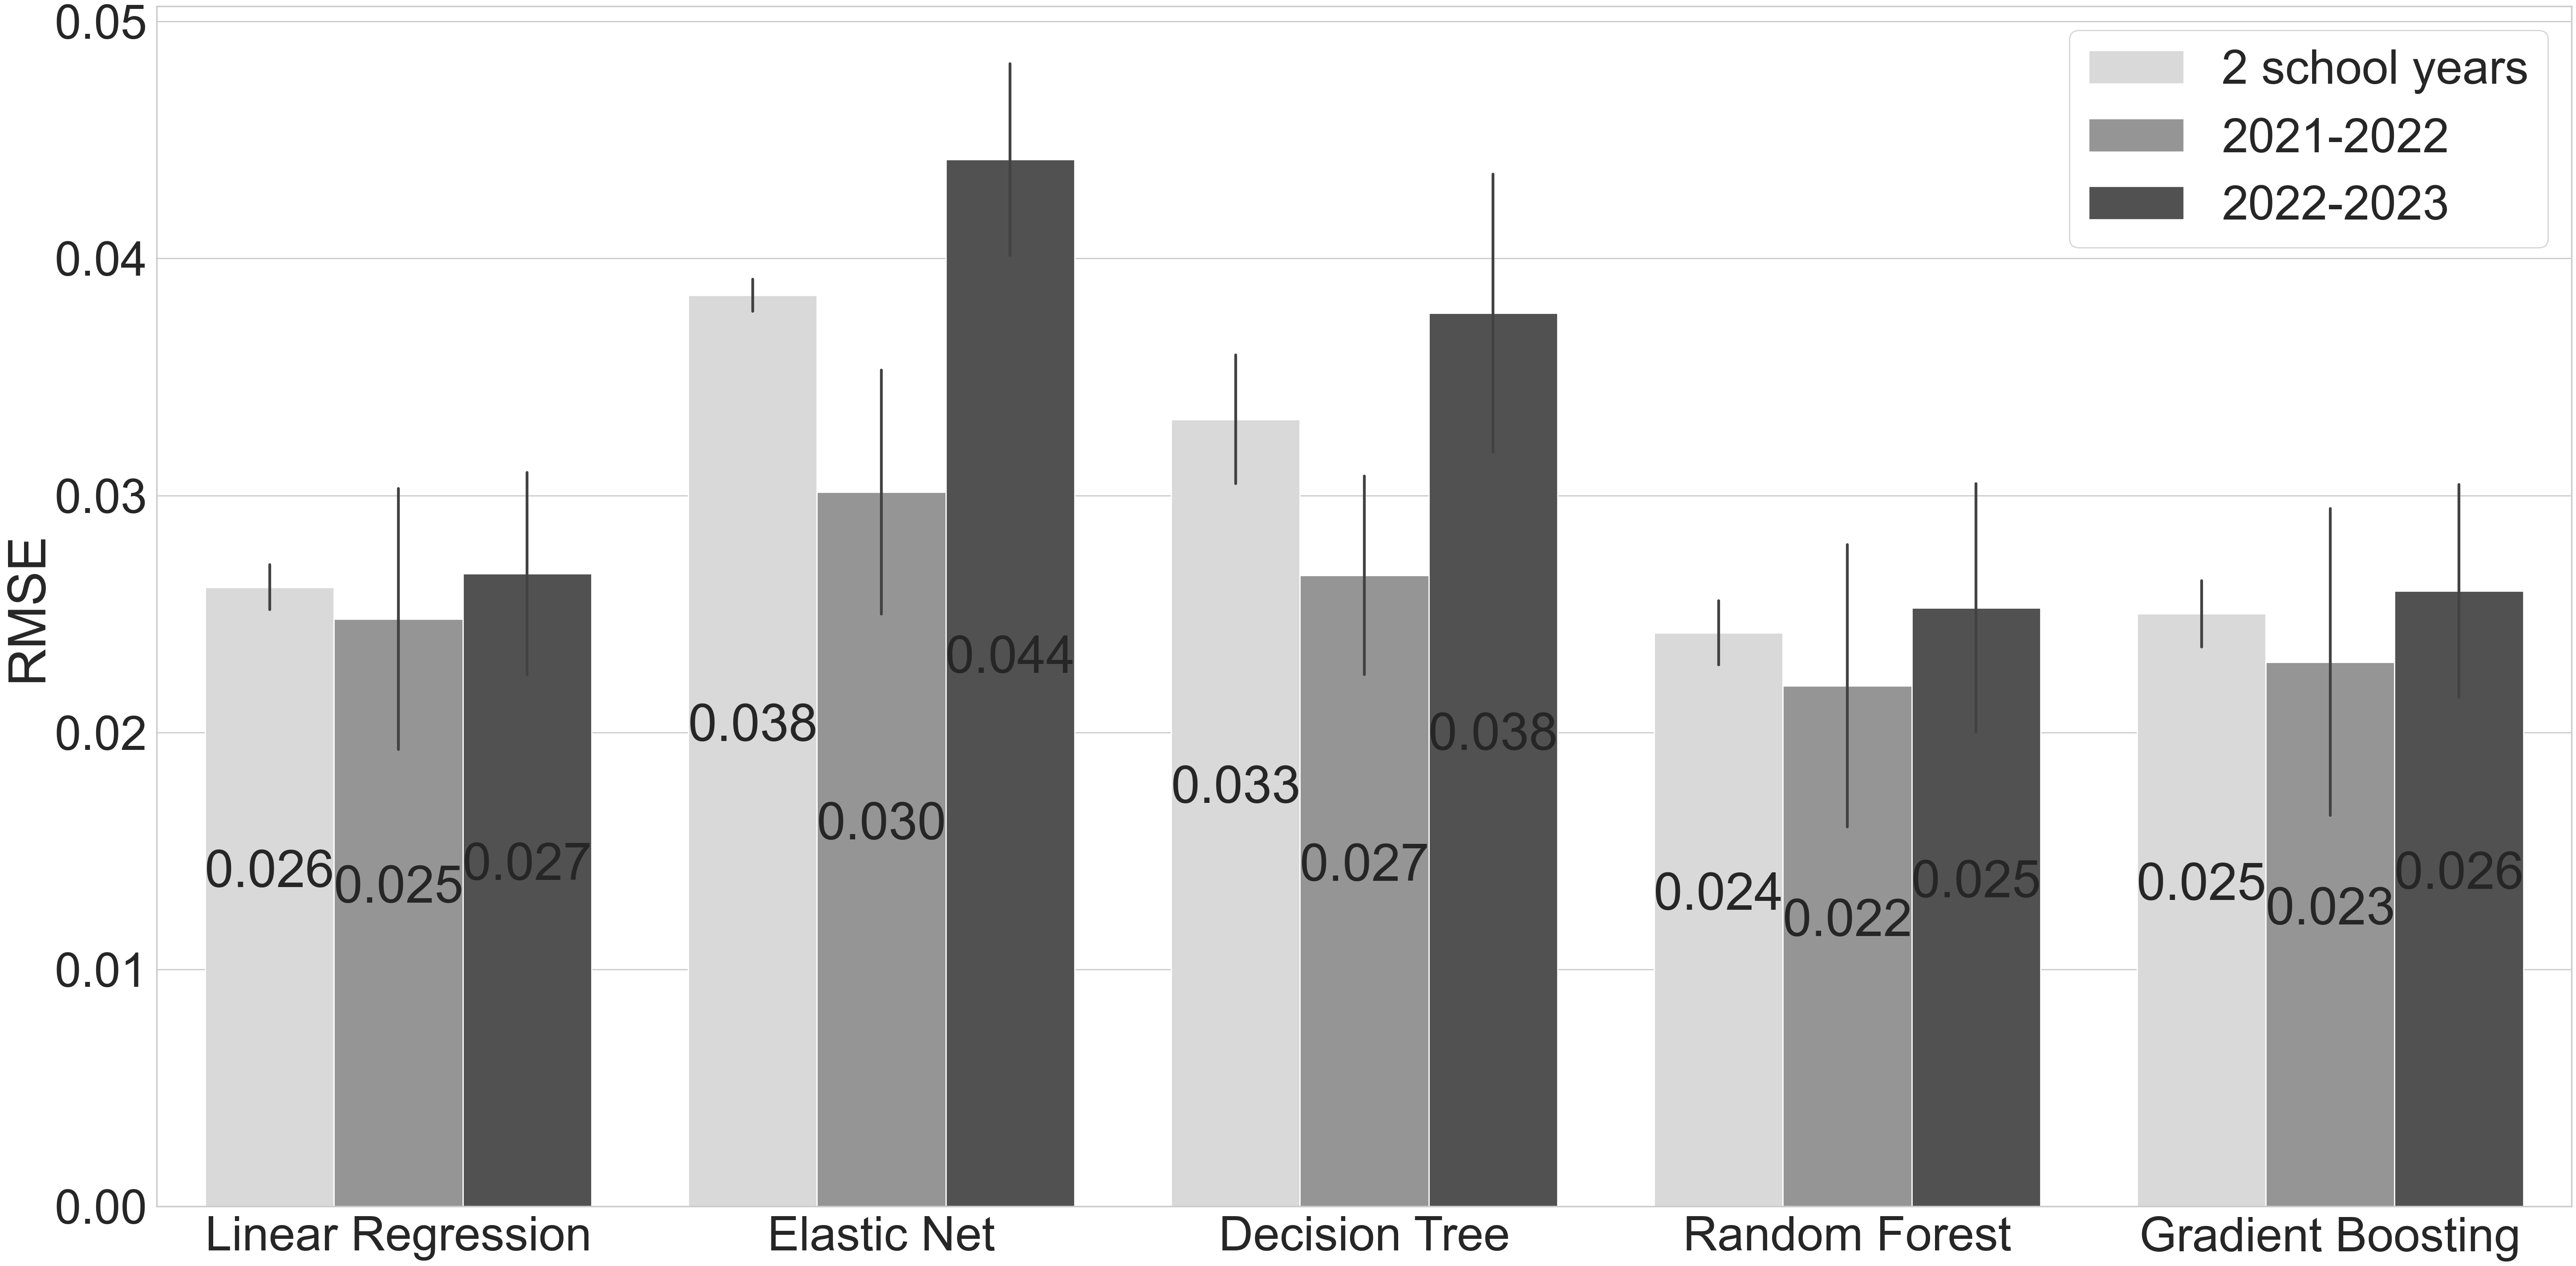

In [354]:
# mpl.rcParams['font.size'] = 30  # applies to all text elements
# plt.rcParams.update(plt.rcParamsDefault)

sns.set_context('poster', font_scale =3.5)


x_order = ["Linear Regression","Elastic Net","Decision Tree",
           "Random Forest","Gradient Boosting"]
hue_order = ["2 school years","2021-2022","2022-2023"]
# hatch_patterns = ["///", "xxx", "...", "\\\\\\", "++"]

plt.figure(figsize=(70,35))
sns.set_style("whitegrid")
ax = sns.barplot(x='Model', y='RMSE', hue='SchoolYear',
                 estimator = 'mean', data=rmse_score_long, errorbar='sd', order=x_order, hue_order=hue_order, palette="Greys"
)

real_bars = ax.patches[:-len(ax.legend_.texts)]

for i, p in enumerate(real_bars):
    height = p.get_height()
    ax.annotate(f"{height:.3f}",
                (p.get_x() + p.get_width() / 2., height/2),
                ha='center', va='bottom')
   
# plt.rcParams['font.family'] = 'Times New Roman'
ax.set_xlabel('')
# Adjust legend position

ax.legend(title="", loc="upper right", frameon=True)
plt.show()

In [91]:

training_splits = [2, 3, 4, 5]
r2_score_splits = pd.DataFrame()
rmse_score_splits = pd.DataFrame()
for n in training_splits:
    models_scores_overall, models_scores_2022, models_scores_2023, r2_score_df, rmse_score_df = ml_train_test(county_ses_vars_dropout_train, transformed_features, target = 'dropout_rate', year = 'both', n_splits = n )
    r2_score_df.rename(columns={'R2_overall': f'R2_overall_split_{n}', 'R2_2022': f'R2_2022_split_{n}', 'R2_2023': f'R2_2023_split_{n}'}, inplace=True)
    r2_score_splits = pd.concat([r2_score_splits, r2_score_df], axis = 1)

    rmse_score_df.rename(columns={'RMSE_overall': f'RMSE_overall_split_{n}', 'RMSE_2022': f'RMSE_2022_split_{n}', 'RMSE_2023': f'RMSE_2023_split_{n}'}, inplace=True)
    rmse_score_splits = pd.concat([rmse_score_splits, rmse_score_df], axis = 1)
rmse_score_splits

/Users/julia/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning: divide by zero encountered in matmul
  return X @ coef_ + self.intercept_
/Users/julia/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning: overflow encountered in matmul
  return X @ coef_ + self.intercept_
/Users/julia/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning: invalid value encountered in matmul
  return X @ coef_ + self.intercept_
/Users/julia/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning: divide by zero encountered in matmul
  return X @ coef_ + self.intercept_
/Users/julia/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning: overflow encountered in matmul
  return X @ coef_ + self.intercept_
/Users/julia/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarn

,RMSE_overall_split_2,RMSE_2022_split_2,RMSE_2023_split_2,RMSE_overall_split_3,RMSE_2022_split_3,RMSE_2023_split_3,RMSE_overall_split_4,RMSE_2022_split_4,RMSE_2023_split_4,RMSE_overall_split_5,RMSE_2022_split_5,RMSE_2023_split_5
LinearRegression,0.026427,0.025389,0.027280,0.026128,0.024953,0.026950,0.025982,0.024910,0.026840,0.026124,0.024786,0.026704
ElasticNet,0.038444,0.030390,0.044258,0.038439,0.030268,0.044235,0.038331,0.030276,0.044131,0.038450,0.030142,0.044169
DecisionTreeRegressor,0.035148,0.030910,0.038447,0.034123,0.031735,0.035699,0.034661,0.031479,0.037077,0.033214,0.026627,0.037693
RandomForestRegressor,0.025897,0.024378,0.027139,0.024724,0.023792,0.025293,0.024484,0.023469,0.025304,0.024205,0.021975,0.025252
GradientBoostingRegressor,0.026403,0.025890,0.026838,0.025245,0.024386,0.025749,0.025638,0.024651,0.026415,0.025010,0.022973,0.025975


/var/folders/5m/t25_cp9j1fz0tdy_cmjc0zgc0000gn/T/ipykernel_30059/1956514086.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  overall_rmse.rename(index= model_map, inplace=True)


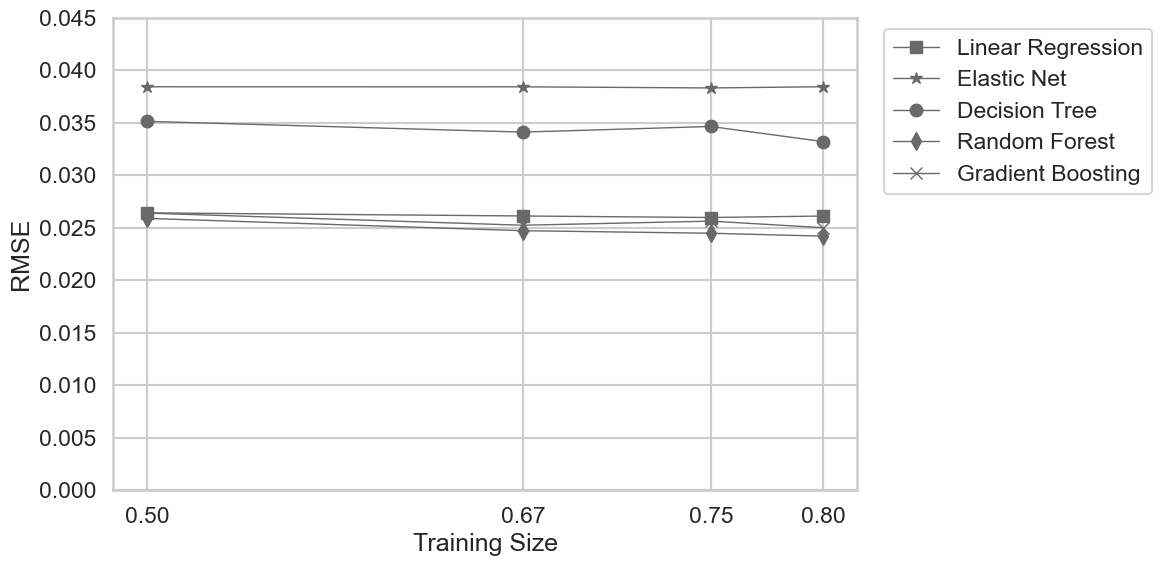

In [355]:
sns.set_context("talk")  # "notebook", 'talk', 'paper', 'poster'
sns.set_style("whitegrid")   # or 'darkgrid', 'white', 'dark'
# sns.set_palette("Greys")      # or 'deep', 'pastel', 'muted', etc.
rmse_score_splits.index.name = 'Model'

# Filter only columns that start with 'RMSE_overall'
overall_rmse = rmse_score_splits.filter(regex='^RMSE_overall_split')

model_map = {'LinearRegression': 'Linear Regression','ElasticNet': 'Elastic Net', 'DecisionTreeRegressor': 'Decision Tree',
                      'RandomForestRegressor': 'Random Forest', 'GradientBoostingRegressor': 'Gradient Boosting'}
overall_rmse.rename(index= model_map, inplace=True)
fig, ax = plt.subplots(figsize=(12, 6))
training_size = [(n-1)/n for n in training_splits]
markers = ['s','*','o','d','x']
for i, model_name in enumerate(overall_rmse.index):
    plt.plot(training_size, overall_rmse.loc[model_name], marker=markers[i], label=model_name, color='dimgray',linewidth=1)

# yaxis from 0
ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))  # Format with 2 decimal places
ax.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
ax.set_yticks(np.arange(0, 0.05, 0.005))
# plt.rcParams['font.family'] = 'Times New Roman'

plt.xlabel('Training Size')
plt.ylabel('RMSE')
# plt.title('RMSE across Training Size for Each Model (2-year)') # caption
plt.xticks(training_size)
# plt.grid(False)
plt.legend(loc='upper left', bbox_to_anchor=(1.02, 1)) 
plt.tight_layout()
plt.savefig('../figure/RMSE_by_training_size_2022_2023.png', dpi=300 )

plt.show()

/var/folders/5m/t25_cp9j1fz0tdy_cmjc0zgc0000gn/T/ipykernel_30059/914987354.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rmse_2023.rename(index= model_map, inplace=True)


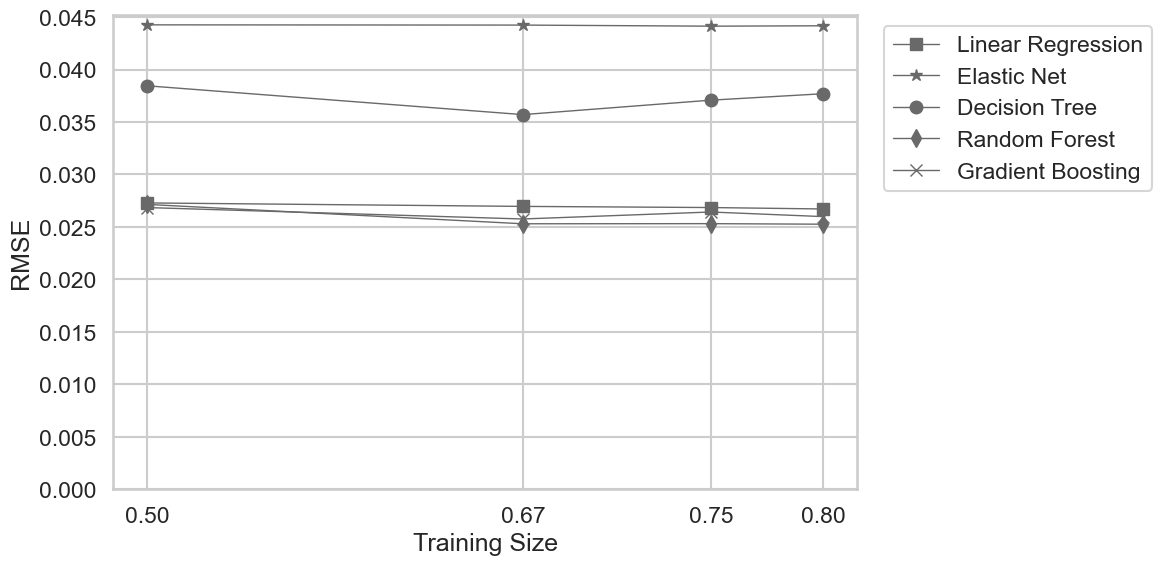

In [356]:
sns.set_context("talk")  # "notebook", 'talk', 'paper', 'poster'
sns.set_style("whitegrid")   # or 'darkgrid', 'white', 'dark'
# sns.set_palette("mako")      # or 'deep', 'pastel', 'muted', etc.
rmse_score_splits.index.name = 'Model'

# Filter only columns that start with 'RMSE_overall'
rmse_2023 = rmse_score_splits.filter(regex='^RMSE_2023_split')

model_map = {'LinearRegression': 'Linear Regression','ElasticNet': 'Elastic Net', 'DecisionTreeRegressor': 'Decision Tree',
                      'RandomForestRegressor': 'Random Forest', 'GradientBoostingRegressor': 'Gradient Boosting'}
rmse_2023.rename(index= model_map, inplace=True)

fig, ax = plt.subplots(figsize=(12, 6))
training_size = [(n-1)/n for n in training_splits]
markers = ['s','*','o','d','x']
for i, model_name in enumerate(rmse_2023.index):
    plt.plot(training_size, rmse_2023.loc[model_name], marker=markers[i], label=model_name, color='dimgray',linewidth=1)

ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))  # Format with 2 decimal places
ax.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
ax.set_yticks(np.arange(0, 0.05, 0.005))
# plt.rcParams['font.family'] = 'Times New Roman'

plt.xlabel('Training Size')
plt.ylabel('RMSE')
# plt.title('RMSE across Training Size for Each Model (2023)')
plt.xticks(training_size)
plt.grid(True)
plt.legend(loc='upper left', bbox_to_anchor=(1.02, 1)) 
plt.tight_layout()
plt.savefig('../figure/RMSE_by_training_size_2023.png', dpi=300 )

plt.show()

In [128]:
r2_score_splits

,R2_overall_split_2,R2_2022_split_2,R2_2023_split_2,R2_overall_split_3,R2_2022_split_3,R2_2023_split_3,R2_overall_split_4,R2_2022_split_4,R2_2023_split_4,R2_overall_split_5,R2_2022_split_5,R2_2023_split_5
LinearRegression,0.544888,0.277082,0.633057,0.555207,0.296177,0.641693,0.559170,0.299230,0.644229,0.554822,0.293107,0.647999
ElasticNet,0.037249,-0.036573,0.033493,0.037445,-0.044551,0.033276,0.035643,-0.039666,0.031267,0.036612,-0.064096,0.032713
DecisionTreeRegressor,0.193491,-0.074651,0.265699,0.237068,-0.137938,0.368976,0.198368,-0.139910,0.308928,0.279586,0.154291,0.295999
RandomForestRegressor,0.562921,0.333337,0.636670,0.601760,0.362187,0.684523,0.608977,0.378994,0.683455,0.617750,0.448874,0.684665
GradientBoostingRegressor,0.546075,0.246071,0.645009,0.584577,0.330602,0.673003,0.570613,0.314433,0.655436,0.591602,0.397425,0.666833


/var/folders/5m/t25_cp9j1fz0tdy_cmjc0zgc0000gn/T/ipykernel_30059/2905409535.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  overall_r2.rename(index= model_map, inplace=True)


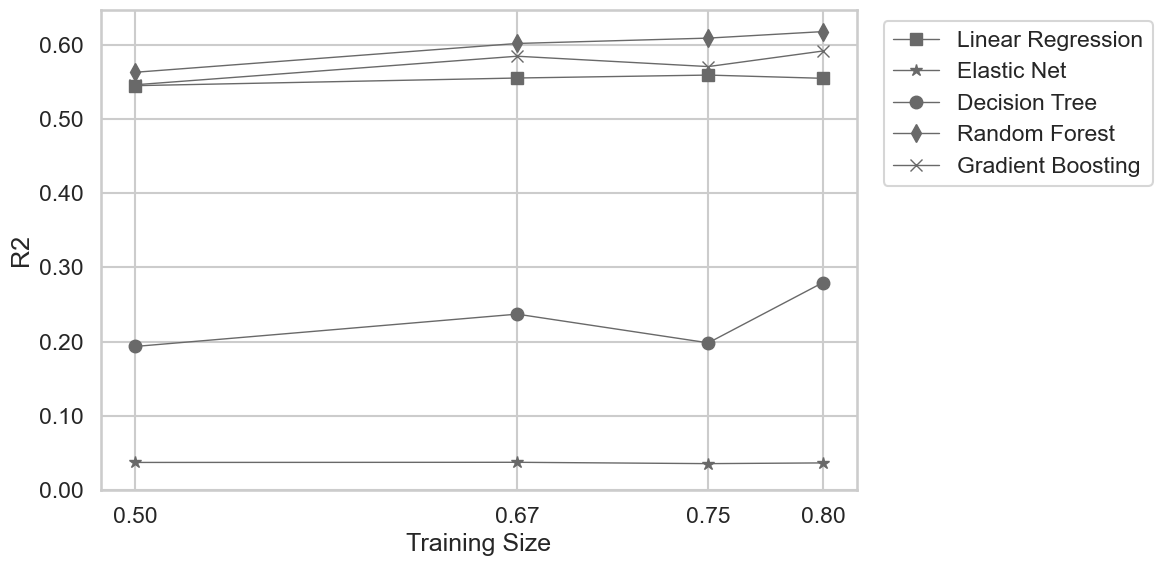

In [357]:
sns.set_context("talk")  # "notebook", 'talk', 'paper', 'poster'
sns.set_style("whitegrid")   # or 'darkgrid', 'white', 'dark'
# sns.set_palette("mako")      # or 'deep', 'pastel', 'muted', etc.
r2_score_splits.index.name = 'Model'

# Filter only columns that start with 'RMSE_overall'
overall_r2 = r2_score_splits.filter(regex='^R2_overall_split')

fig, ax = plt.subplots(figsize=(12, 6))
training_size = [(n-1)/n for n in training_splits]
markers = ['s','*','o','d','x']
model_map = {'LinearRegression': 'Linear Regression','ElasticNet': 'Elastic Net', 'DecisionTreeRegressor': 'Decision Tree',
                      'RandomForestRegressor': 'Random Forest', 'GradientBoostingRegressor': 'Gradient Boosting'}
overall_r2.rename(index= model_map, inplace=True)

for i, model_name in enumerate(overall_r2.index):
    plt.plot(training_size, overall_r2.loc[model_name], marker=markers[i], label=model_name, color='dimgray',linewidth=1)

ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))  # Format with 2 decimal places
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax.set_yticks(np.arange(0, 0.7, 0.1))
# plt.rcParams['font.family'] = 'Times New Roman'

plt.xlabel('Training Size')
plt.ylabel('R2')
# plt.title('R2 across Training Size for Each Model (2-year)')
plt.xticks(training_size)
plt.grid(True)
plt.legend(loc='upper left', bbox_to_anchor=(1.02, 1))
plt.tight_layout()
plt.savefig('../figure/R2_by_training_size_2022_2023.png', dpi=300 )
plt.show()

/var/folders/5m/t25_cp9j1fz0tdy_cmjc0zgc0000gn/T/ipykernel_30059/2606222572.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  r2_2023.rename(index= model_map, inplace=True)


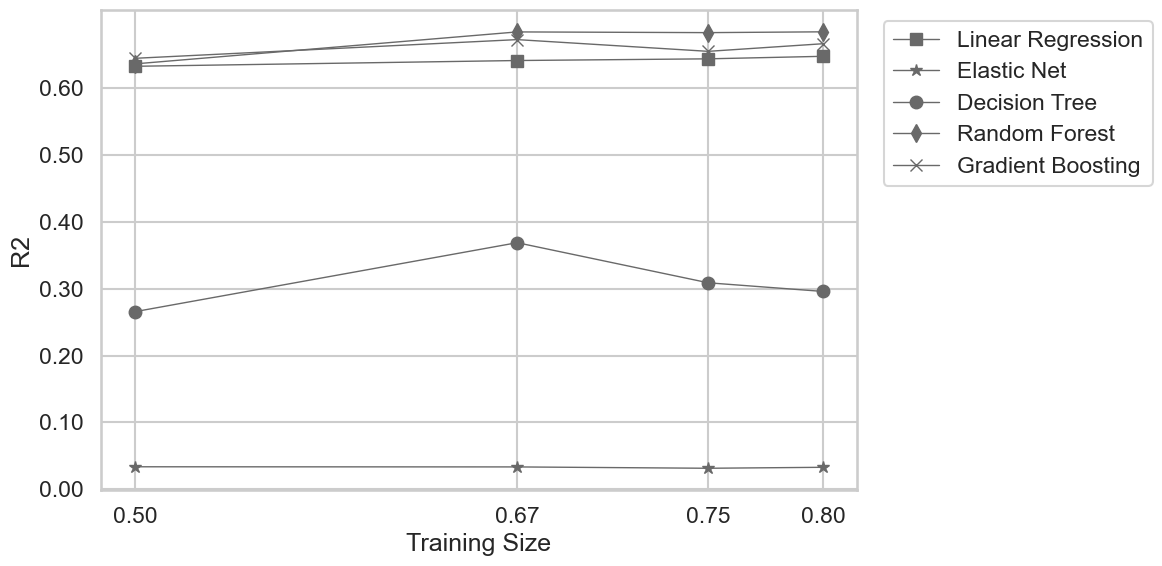

In [358]:
sns.set_context("talk")  # "notebook", 'talk', 'paper', 'poster'
sns.set_style("whitegrid")   # or 'darkgrid', 'white', 'dark'
sns.set_palette("mako")      # or 'deep', 'pastel', 'muted', etc.
rmse_score_splits.index.name = 'Model'

# Filter only columns that start with 'RMSE_overall'
r2_2023 = r2_score_splits.filter(regex='^R2_2023_split')
model_map = {'LinearRegression': 'Linear Regression','ElasticNet': 'Elastic Net', 'DecisionTreeRegressor': 'Decision Tree',
                      'RandomForestRegressor': 'Random Forest', 'GradientBoostingRegressor': 'Gradient Boosting'}
r2_2023.rename(index= model_map, inplace=True)
fig, ax = plt.subplots(figsize=(12, 6))
training_size = [(n-1)/n for n in training_splits]
markers = ['s','*','o','d','x']

for i, model_name in enumerate(r2_2023.index):
    plt.plot(training_size, r2_2023.loc[model_name], marker=markers[i], label=model_name, color='dimgray',linewidth=1)

ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))  # Format with 2 decimal places
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax.set_yticks(np.arange(0, 0.7, 0.1))
# plt.rcParams['font.family'] = 'Times New Roman'
plt.xlabel('Training Size')
plt.ylabel('R2')
# plt.title('R2 across Training Size for Each Model (2023)')
plt.xticks(training_size)
plt.grid(True)
plt.legend(loc='upper left', bbox_to_anchor=(1.02, 1))
plt.tight_layout()
plt.savefig('../figure/R2_by_training_size_2023.png', dpi=300 )
plt.show()

In [ ]:
county_ses_vars_dropout_disadvantaged_train = county_ses_vars[county_ses_vars['dropout_economically_disadvantaged_rate'].notna()].reset_index(drop=True)
models_scores_overall_dis, models_scores_2022_dis, models_scores_2023_dis, r2_score_dis_df, rmse_score_dis_df = ml_train_test(county_ses_vars_dropout_disadvantaged_train, transformed_features, target = 'dropout_economically_disadvantaged_rate', year = 'both' )
models_scores_overall_dis

In [332]:
r2_score_dis_df.groupby('Model')['R2_overall'].agg('mean')

Model
DecisionTreeRegressor        0.312522
ElasticNet                   0.015890
GradientBoostingRegressor    0.601246
LinearRegression             0.600226
RandomForestRegressor        0.631465
Name: R2_overall, dtype: float64

In [333]:
r2_score_dis_df.groupby('Model')['R2_2022'].agg('mean')

Model
DecisionTreeRegressor       -0.105475
ElasticNet                  -0.273174
GradientBoostingRegressor    0.354627
LinearRegression             0.317266
RandomForestRegressor        0.433317
Name: R2_2022, dtype: float64

In [334]:
r2_score_dis_df.groupby('Model')['R2_2023'].agg('mean')

Model
DecisionTreeRegressor        0.344295
ElasticNet                  -0.004625
GradientBoostingRegressor    0.633606
LinearRegression             0.645255
RandomForestRegressor        0.655546
Name: R2_2023, dtype: float64

In [338]:
year_map = {
    "RMSE_overall": "2 school years",
    "RMSE_2022": "2021-2022",
    "RMSE_2023": "2022-2023"
}

rmse_score_long_dis = (
    rmse_score_dis_df.melt(id_vars="Model",
            value_vars=["RMSE_overall","RMSE_2022","RMSE_2023"],
            var_name="YearCol", value_name="RMSE")
      .assign(SchoolYear=lambda x: x["YearCol"].map(year_map))
      .drop(columns="YearCol")
)
model_map = {'LinearRegression': 'Linear Regression','ElasticNet': 'Elastic Net', 'DecisionTreeRegressor': 'Decision Tree',
                      'RandomForestRegressor': 'Random Forest', 'GradientBoostingRegressor': 'Gradient Boosting'}
rmse_score_long_dis['Model'] = rmse_score_long_dis['Model'].map(model_map)
rmse_score_long_dis

,Model,RMSE,SchoolYear
0,Linear Regression,0.034243,2 school years
1,Linear Regression,0.035984,2 school years
2,Linear Regression,0.029995,2 school years
3,Linear Regression,0.033210,2 school years
4,Linear Regression,0.036272,2 school years
...,...,...,...
70,Gradient Boosting,0.037095,2022-2023
71,Gradient Boosting,0.039305,2022-2023
72,Gradient Boosting,0.035027,2022-2023
73,Gradient Boosting,0.038800,2022-2023


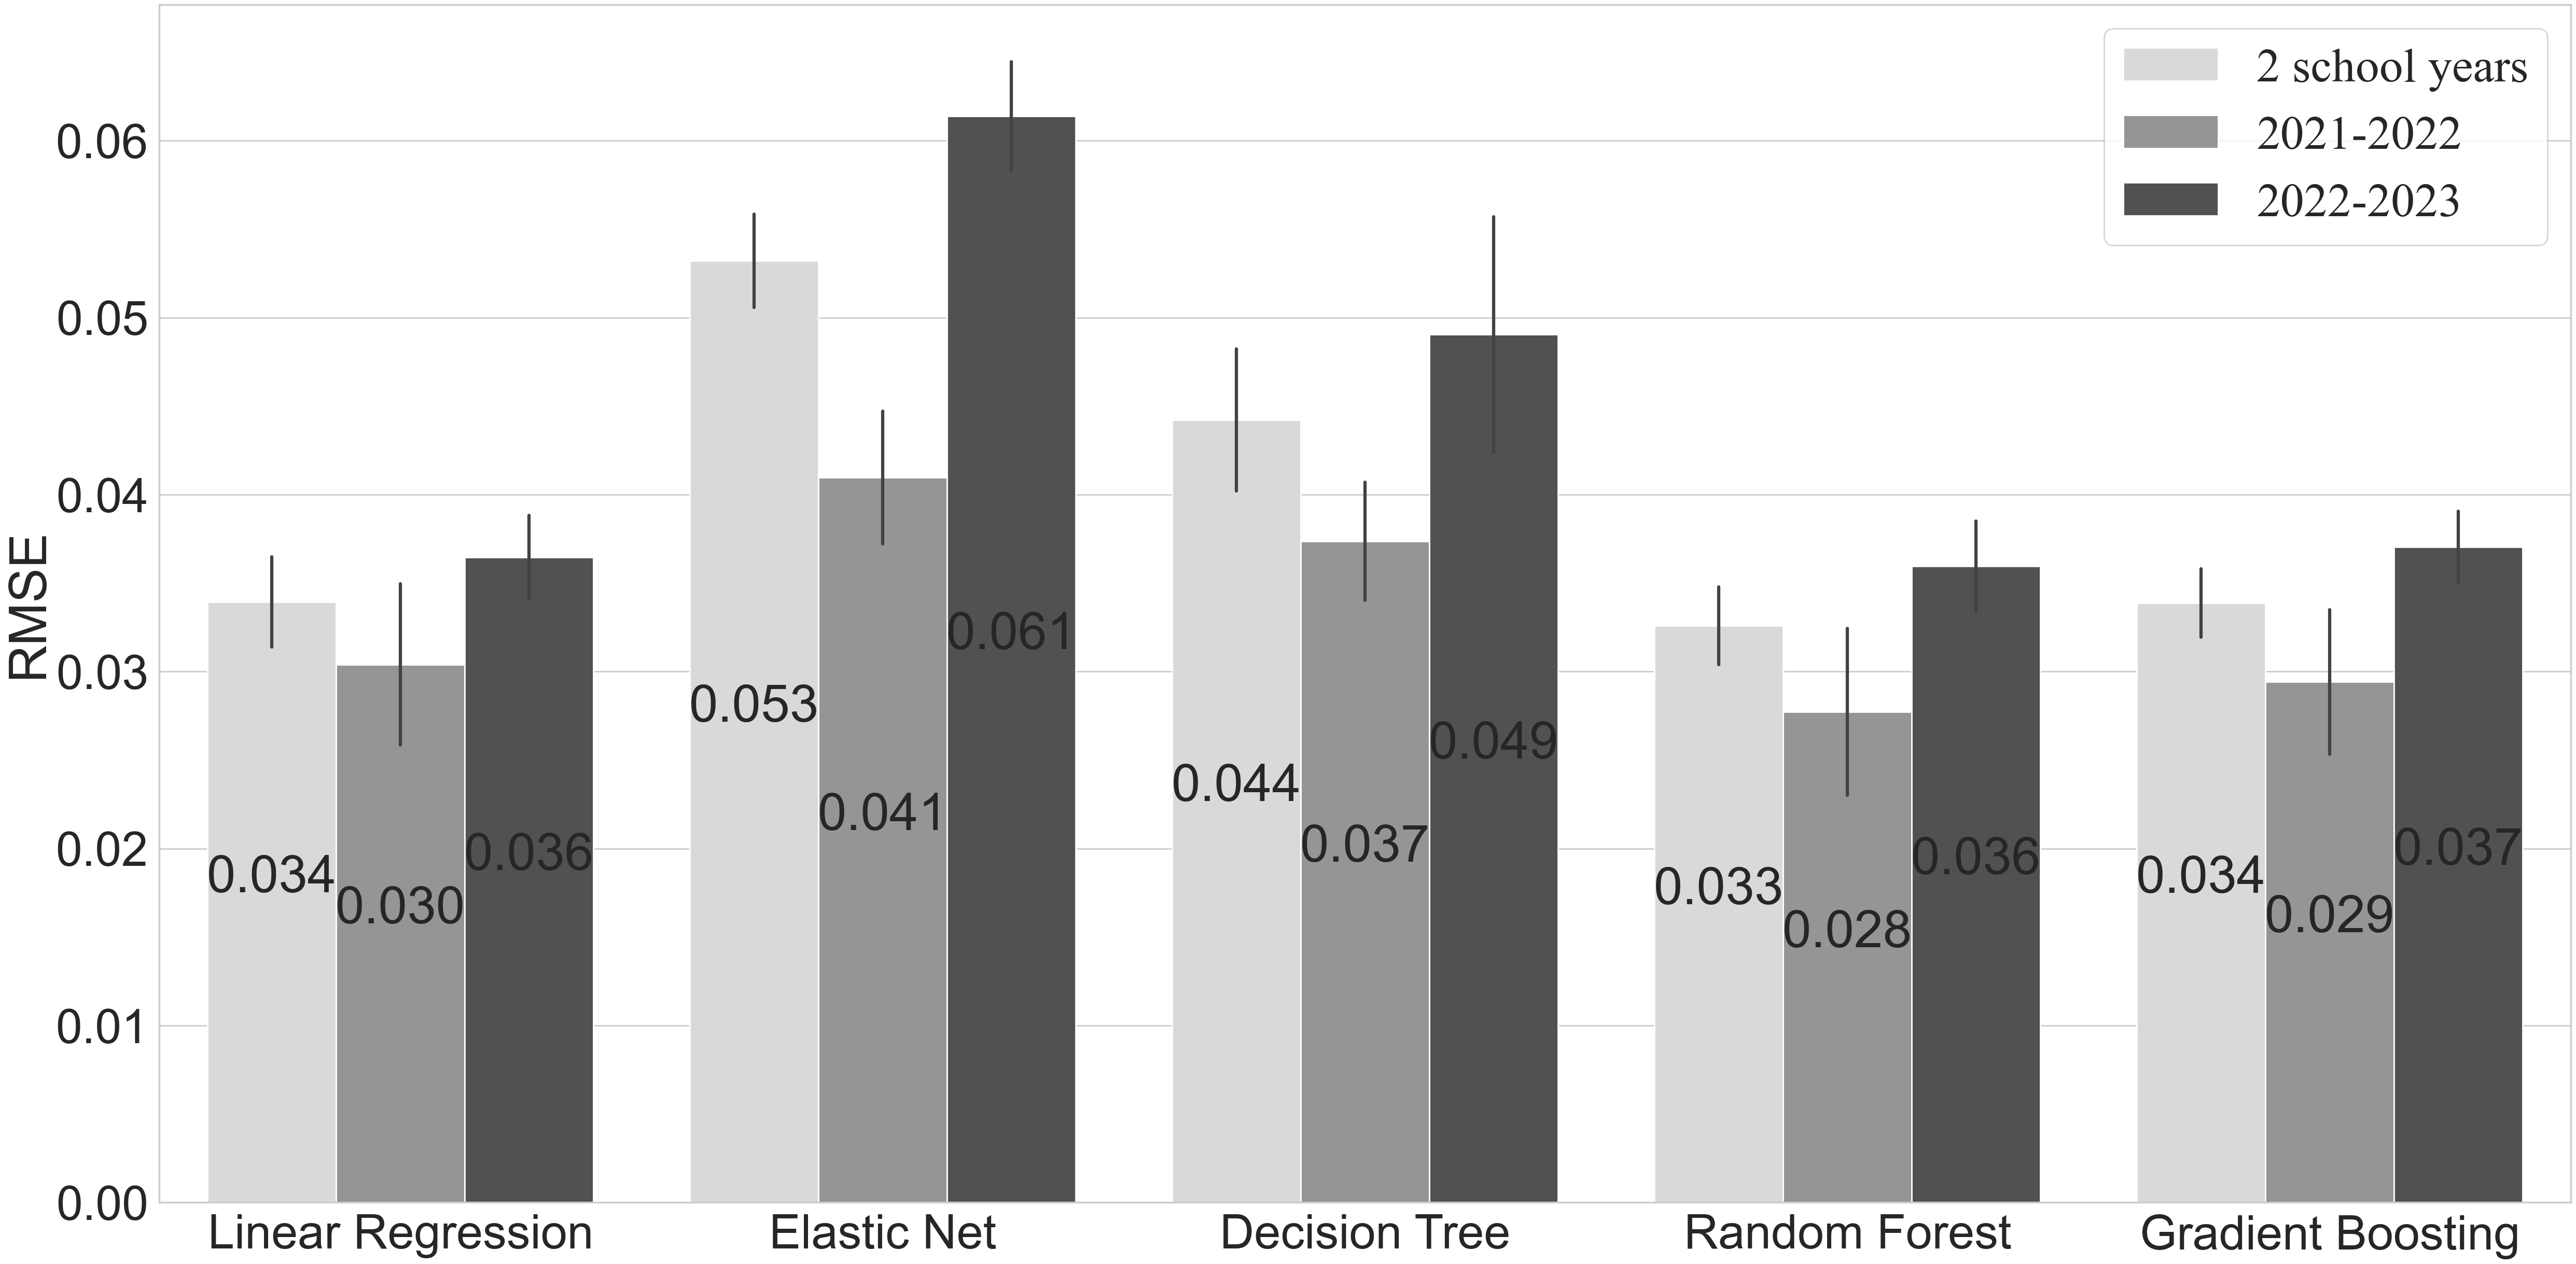

In [339]:
# mpl.rcParams['font.size'] = 30  # applies to all text elements
# plt.rcParams.update(plt.rcParamsDefault)

sns.set_context('poster', font_scale =3)


x_order = ["Linear Regression","Elastic Net","Decision Tree",
           "Random Forest","Gradient Boosting"]
hue_order = ["2 school years","2021-2022","2022-2023"]
# hatch_patterns = ["///", "xxx", "...", "\\\\\\", "++"]

plt.figure(figsize=(60,30))
sns.set_style("whitegrid")
ax = sns.barplot(x='Model', y='RMSE', hue='SchoolYear',
                 estimator = 'mean', data=rmse_score_long_dis, errorbar='sd', order=x_order, hue_order=hue_order, palette="Greys"
)

real_bars = ax.patches[:-len(ax.legend_.texts)]

for i, p in enumerate(real_bars):
    height = p.get_height()
    ax.annotate(f"{height:.3f}",
                (p.get_x() + p.get_width() / 2., height/2),
                ha='center', va='bottom')
   
plt.rcParams['font.family'] = 'Times New Roman'
ax.set_xlabel('')
# Adjust legend position

ax.legend(title="", loc="upper right", frameon=True)
plt.show()